In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) == 3
# to allow other tensorflow processes to use the gpu
# https://stackoverflow.com/a/60699372/7989988
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten
import tensorflow_probability as tfp
from dotmap import DotMap

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [2]:
import models
import training
import datasets
import vizualization
import schedules

# todo
# - combine shuffled and unshuffled datasets into same thing
# - add extra shuffled indices and noise
# - add "noise fraction" parameter which can be changed the same way as the "n" parameter.
# - add different amounts of noise to the data and see what happens

In [3]:
config = DotMap({
    'ds': 'mnist',
    'distributed': True,
    'minibatch_size': 8,
    'n_steps': 120001,
    'test_size': 300,
    'test_minibatch_size': 100,
    'test_interval': 5000,
    'test_n_shuf': [1, 64, 128, 256],
    'test_n_seq': [1, 128, 256, 512],
    'test_autoregressive': False,
    'noise_fraction': 0.04,
    'display_images': True,
    'display_image_interval': 5000,
    'dont_display_until_loss': 0.45,
    'bg_color': [1.0, 0.4, 0.6],
    'lr_schedule': None,
    'lr_warmup_steps': 300,
    'max_lr': 0.0001,
    'min_lr': 0.0001,
    'grad_accum_steps': None, #['exponential', 1, 4],
    'max_accum_steps': 4,
    'use_wandb': True,
    'wandb_log_interval': 10,
    'loss_window_size': 500,
    'kmeans_batch_size': 1000,
})

# need to change for multiworkerstrategy
if config.distributed:
    config.num_devices = len(physical_devices)
else:
    config.num_devices = 1
config.global_batch_size = config.minibatch_size * config.num_devices

In [4]:
gamma_dist, gamma_name = datasets.gamma_distribution_7x7()


In [5]:
# idea is to not have to re-run this cell for subsequent training runs unless the centroids change

ds_configs = DotMap({
    'mnist': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'image_size': (28, 28),
    },
    'mnist_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'mnist_binary_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 2,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
})

config.dataset = ds_configs[config.ds]

dataset, metadata = tfds.load(config.dataset.name, with_info=True, as_supervised=True)

ds_train_original = dataset['train']
ds_test_original = dataset['test']

centroids = datasets.find_centroids(config, ds_train_original)

ds = datasets.Datasets(config, ds_train_original, ds_test_original, centroids, gamma_dist)
viz = vizualization.Viz(config, ds, centroids)
ds_train, ds_test = ds.make_datasets()


centroids.shape (4, 1)


Not using gradient accumulation


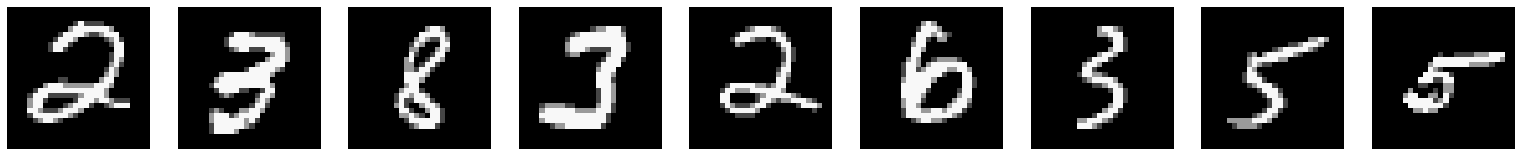

In [6]:
display_colors, display_idxs, *_ = next(iter(ds_train))
if config.grad_accum_steps:
    display_colors,display_idxs = display_colors[0],display_idxs[0]
viz.showSeq(display_colors, display_idxs, config.dataset.image_size, max_images=9)

In [7]:


# model config
config.model = DotMap({
    'n_colors': config.dataset.n_colors,
    'n_color_dims': config.dataset.n_color_dims,
    'include_input_in_target': True,
    'n_enc_a_layers': 4,
    'n_enc_b_layers': 3,
    'ffl_dim': 600,
    'embd_dim': 812,
    'n_dec_layers': 1,
    'dec_dim': 600,
    'n_heads': 4,
    'dropout_rate': 0.05,
    'use_idxs_input': True,
    'architecture': 'anp',
    'position_embedding': 'pos_enc',
    'activation': 'swish',
})

if config.distributed == False:
    strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = models.transformer(config.model)
    # Adam params taken from the linked notebook
    optimizer = keras.optimizers.Adam(learning_rate=config.max_lr)

ds_train_dist = strategy.experimental_distribute_dataset(ds_train)

config.training_mode = 'full_combination'

import socket
model_name = models.model_name(socket.gethostname(), config)
print(model_name)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


cuda7.ecs.vuw.ac.nz-28x28-noise0.04-bs3x1x8


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: maxeonyx (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/clarkemaxw/.cache/pypoetry/virtualenvs/msc-r6Gz9mJU-py3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("StatefulPartitionedCall:2", shape=(None,), dtype=int32), values=Tensor("StatefulPartitionedCall:1", shape=(None, 812), dtype=float32), dense_shape=Tensor("StatefulPartitionedCall:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/clarkemaxw/.cache/pypoetry/virtualenvs/msc-r6Gz9mJU-py3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("StatefulPartitionedCall_1:2", shape=(None,), dtype=int32), values=Tensor("StatefulPartitionedCall_1:1", shape=(None, 812), dtype=float32), dense_shape=Tensor("StatefulPartitionedCall_1:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This m

INFO:tensorflow:batch_all_reduce: 71 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 71 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 71 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 71 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Step 0, Loss (last minibatch): 4.707393646240234, Loss (500 step avg.): 4.707393646240234


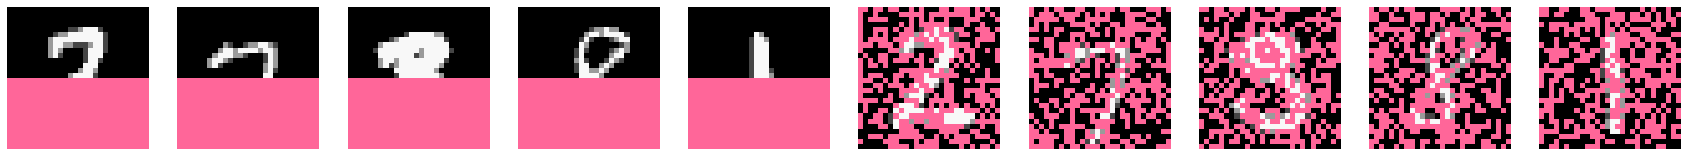

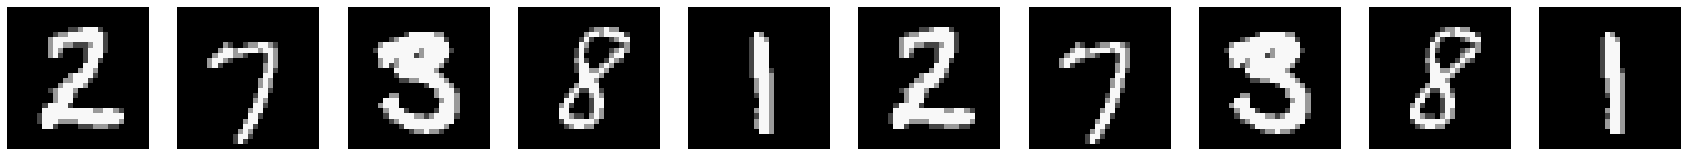

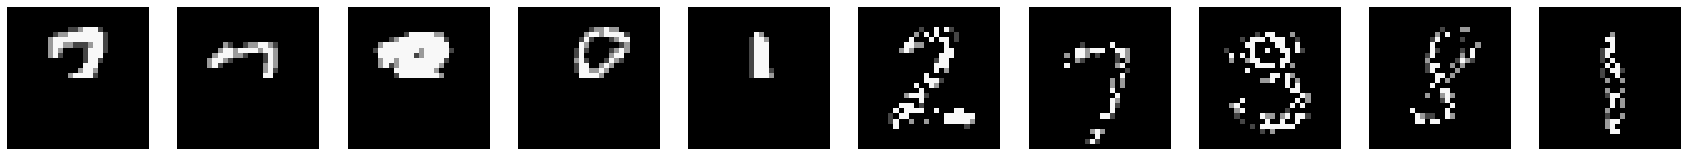

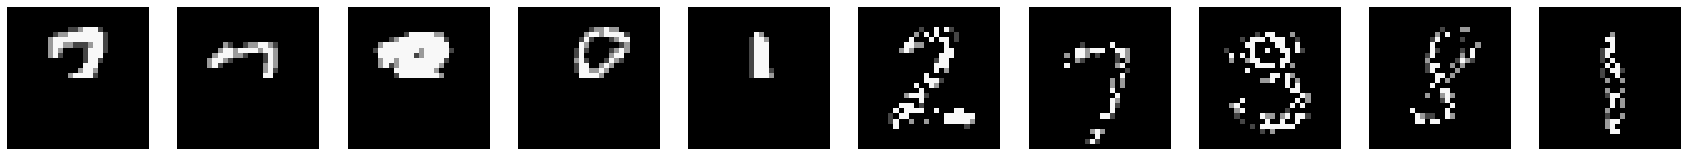

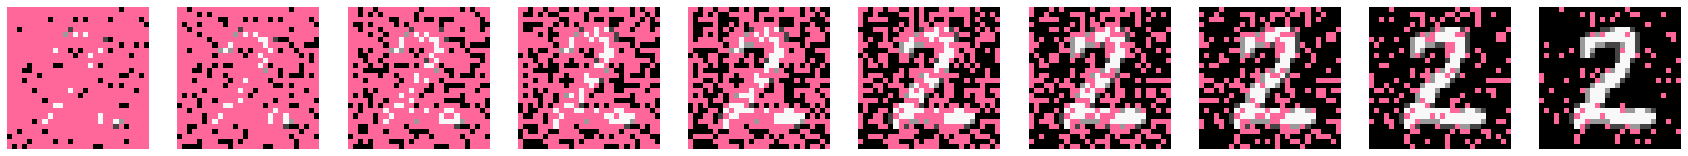

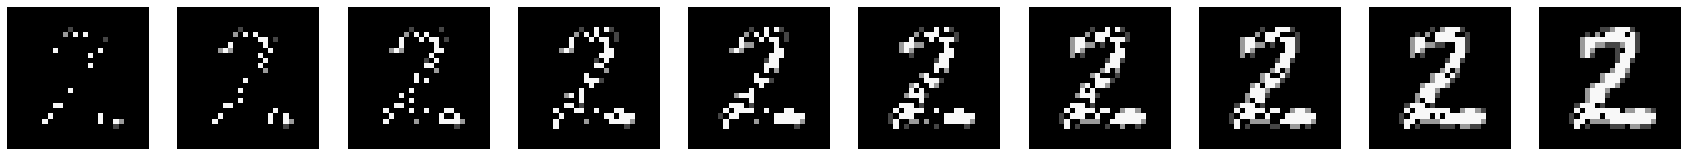

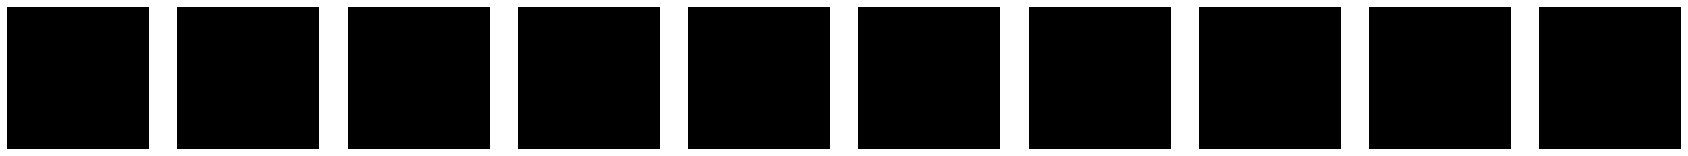

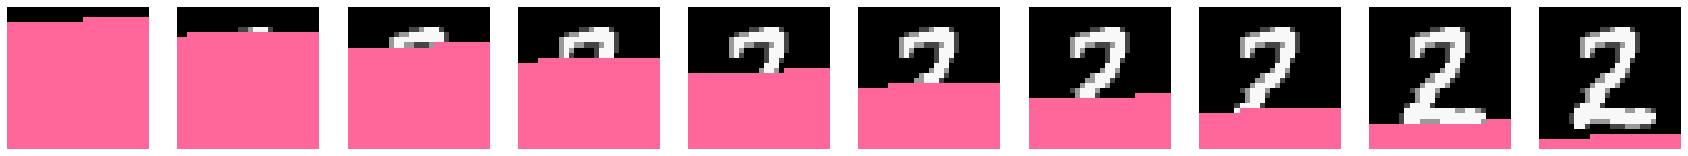

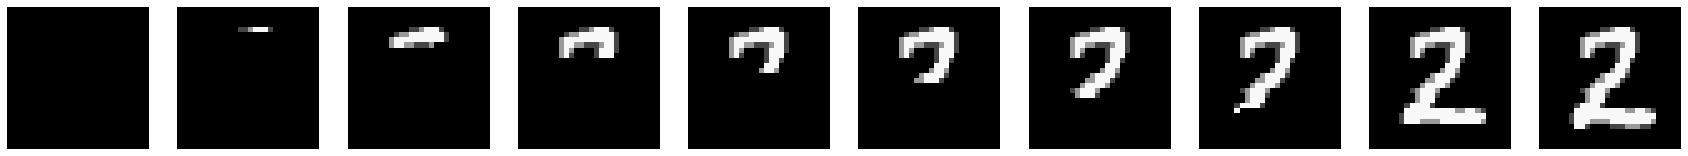

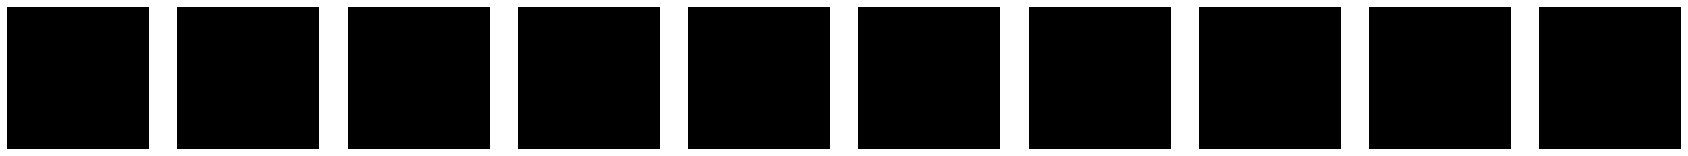

Step 805, Loss (last minibatch): 0.44292914867401123, Loss (500 step avg.): 0.449976915251947


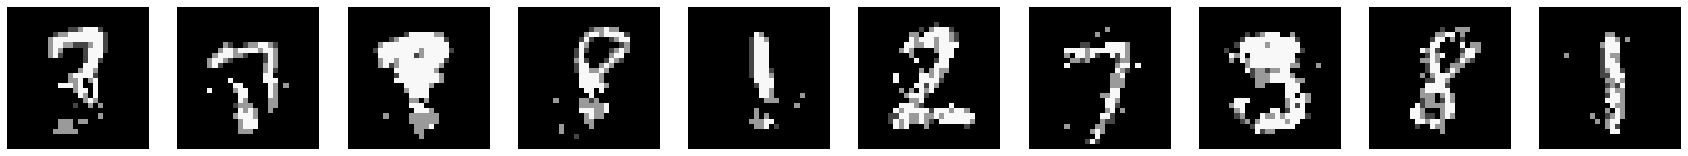

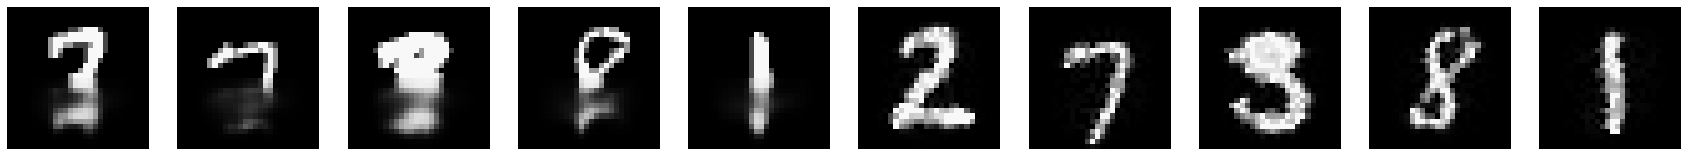

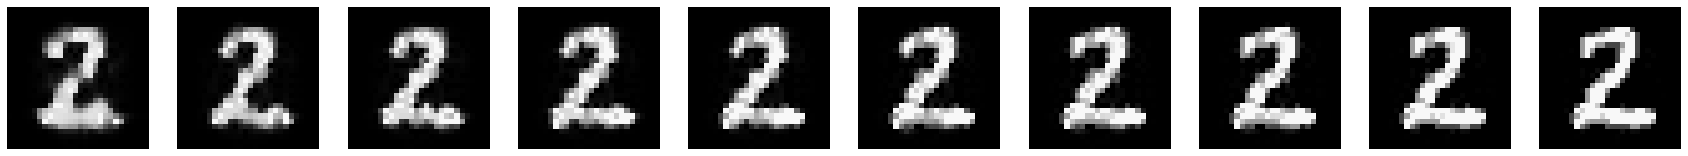

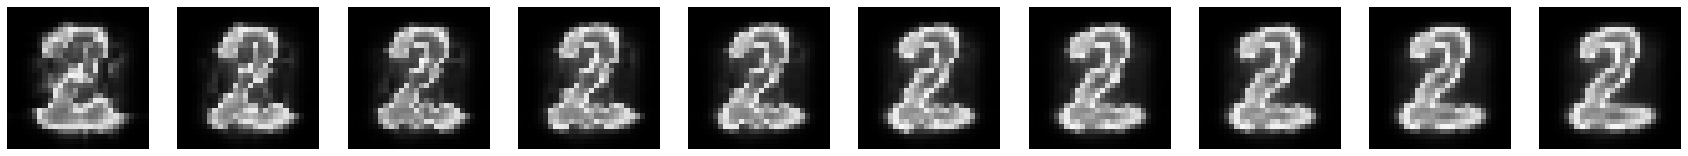

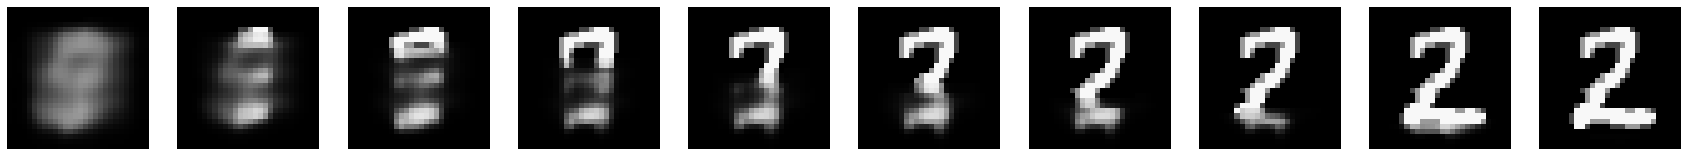

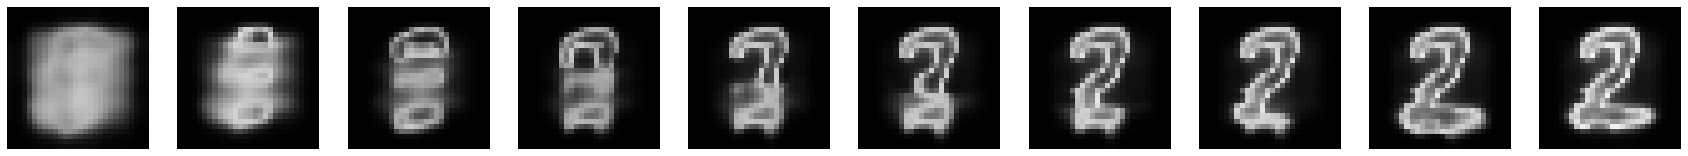

Step 1170, Loss (last minibatch): 0.2762386202812195, Loss (500 step avg.): 0.40481051142344215


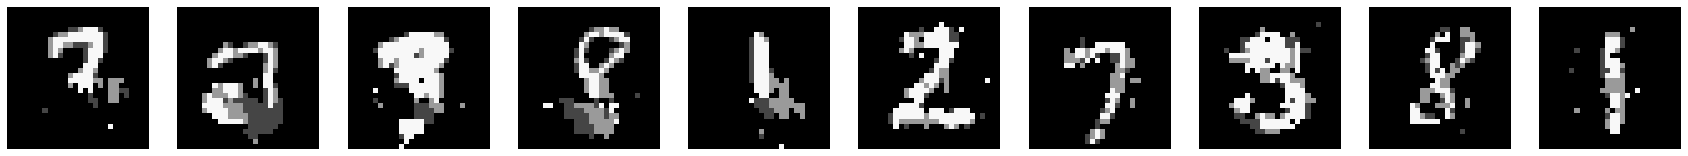

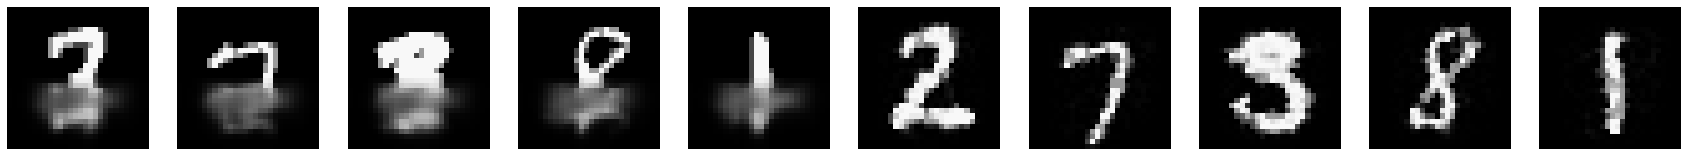

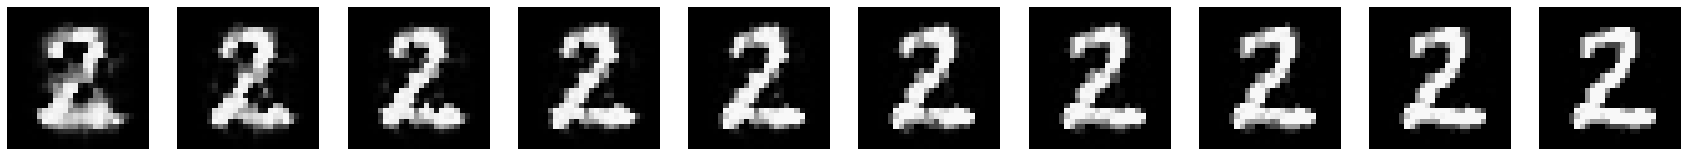

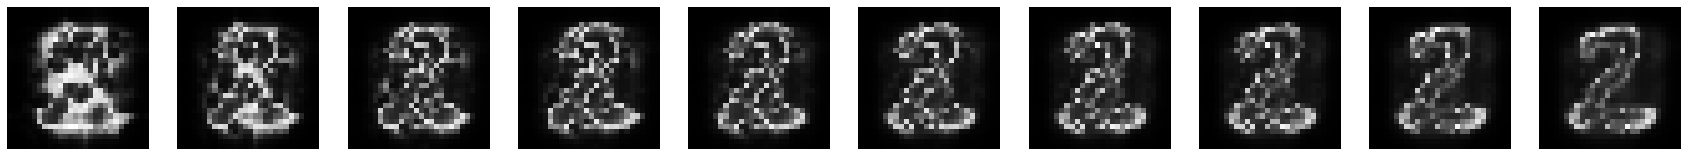

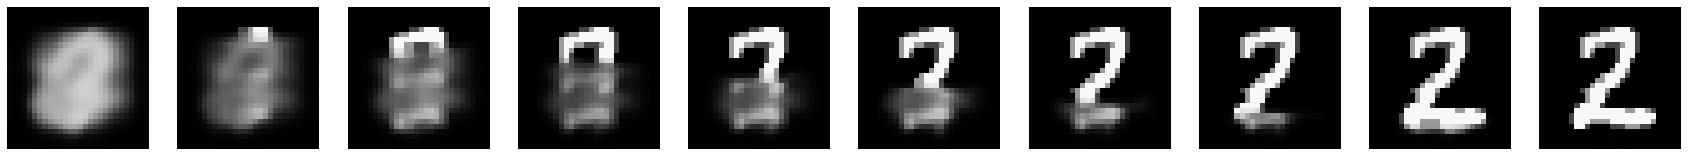

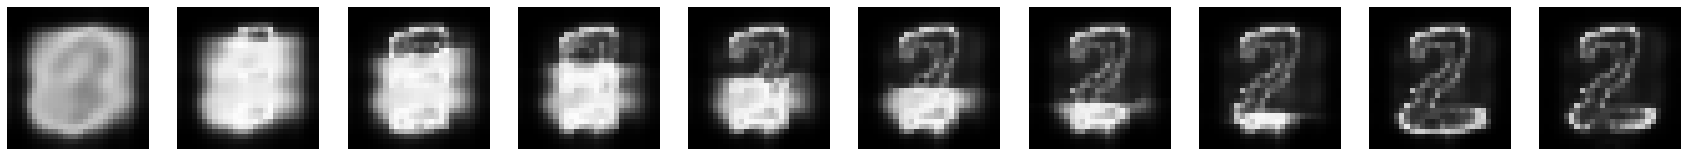

Step 1347, Loss (last minibatch): 0.2792944312095642, Loss (500 step avg.): 0.3627601372386643


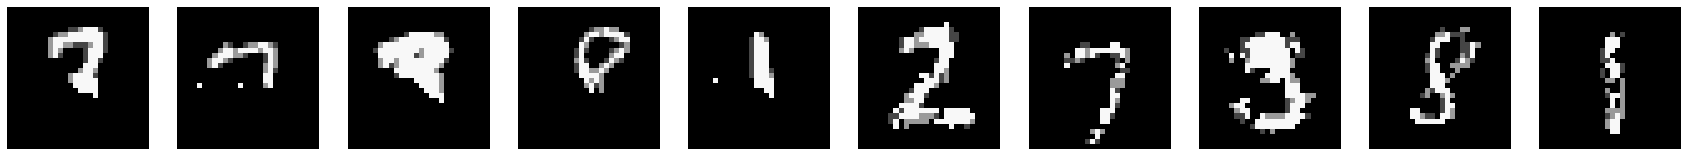

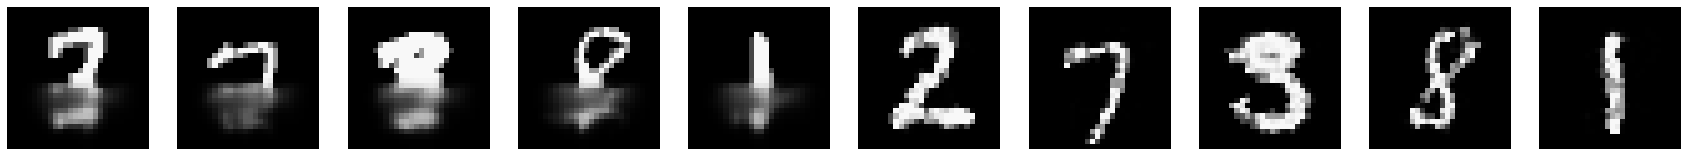

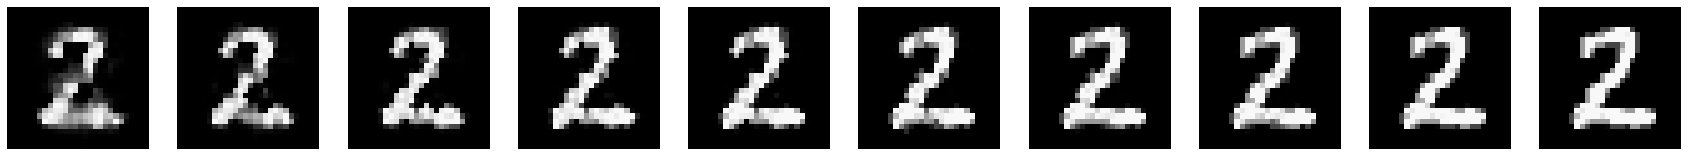

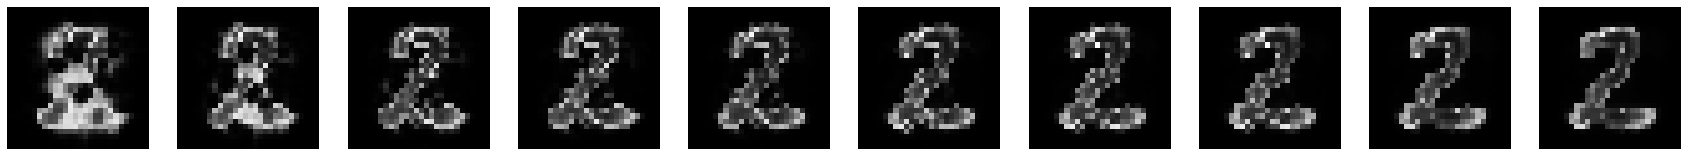

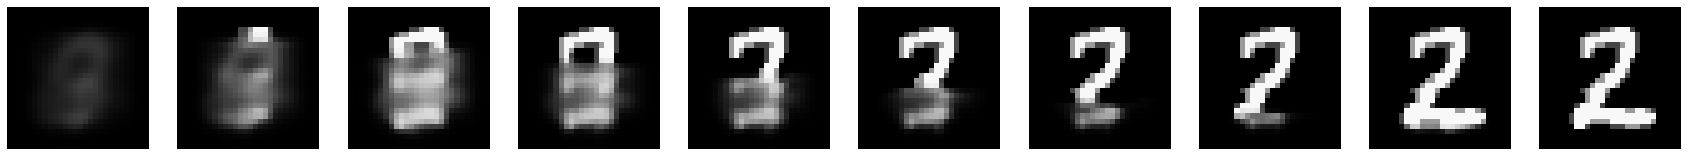

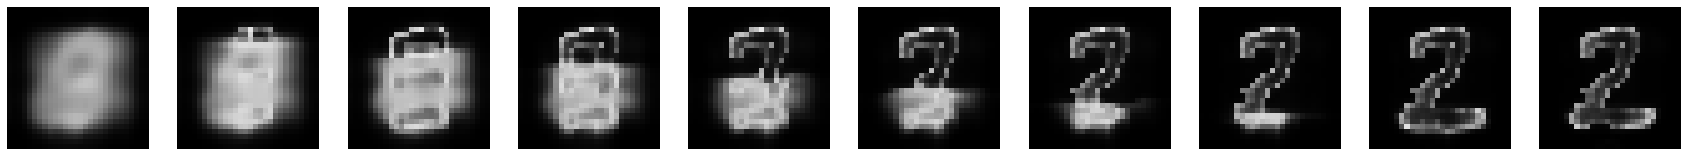

Step 1394, Loss (last minibatch): 0.2806844115257263, Loss (500 step avg.): 0.3264302799028313


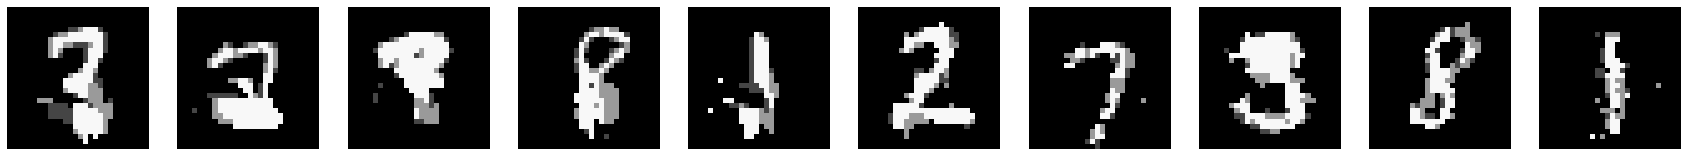

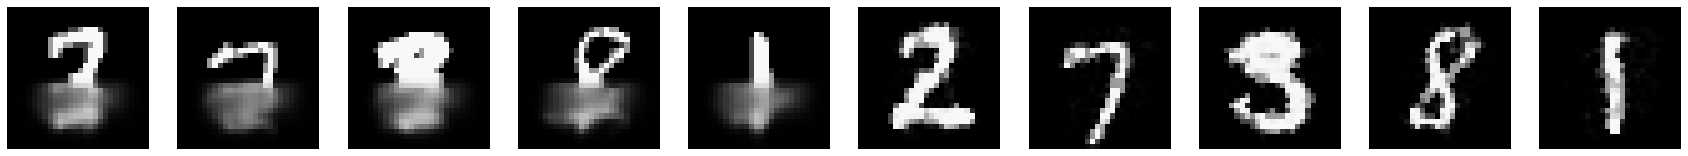

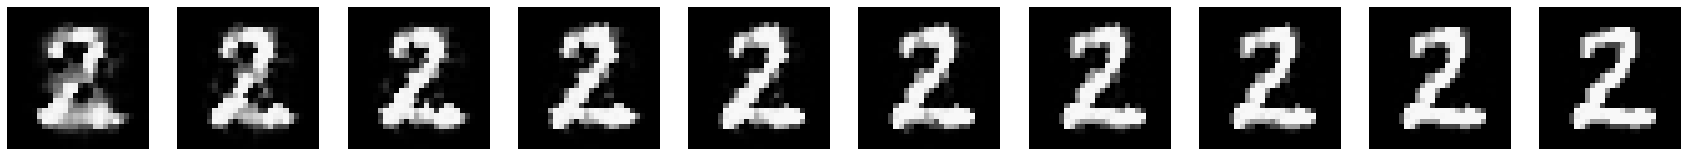

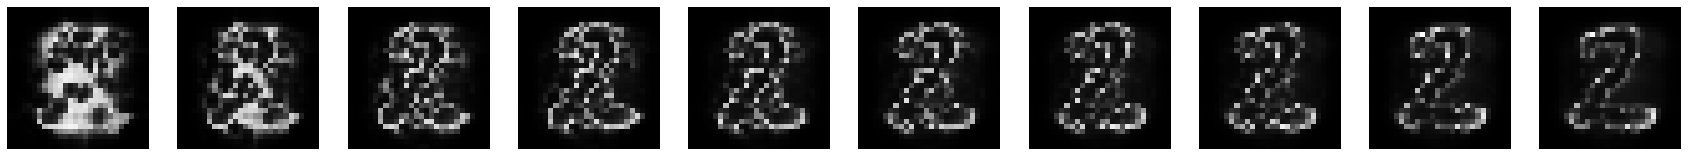

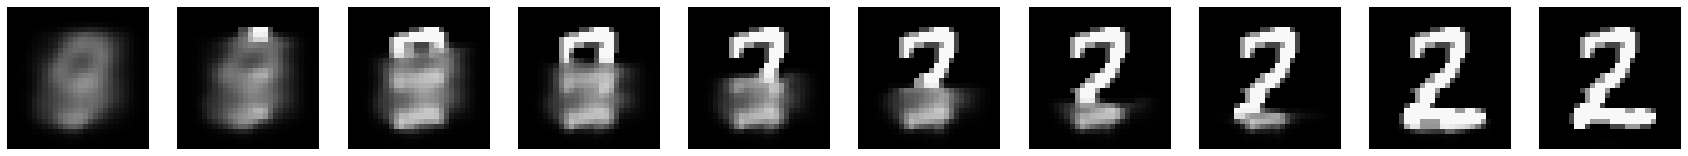

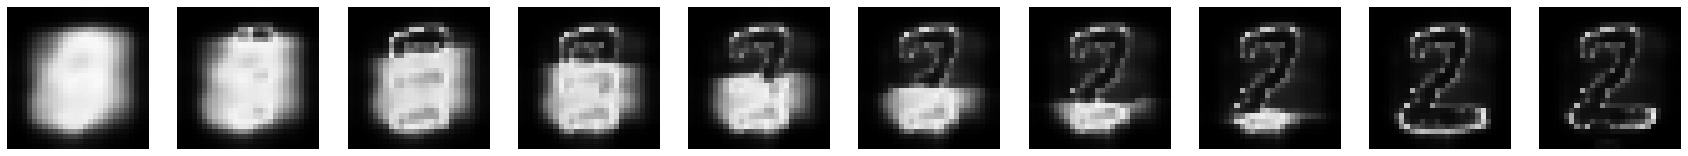

Step 1808, Loss (last minibatch): 0.26916807889938354, Loss (500 step avg.): 0.2937465445129219


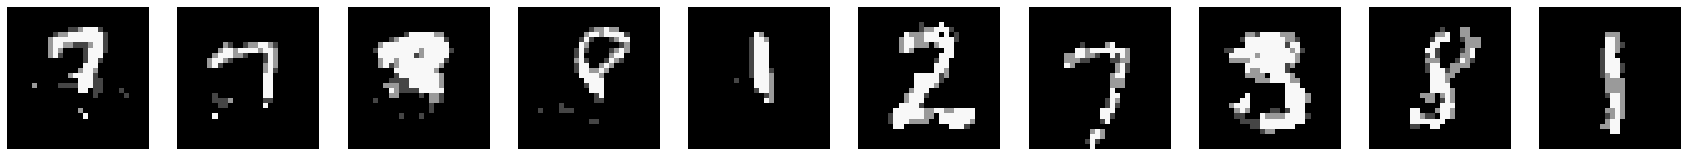

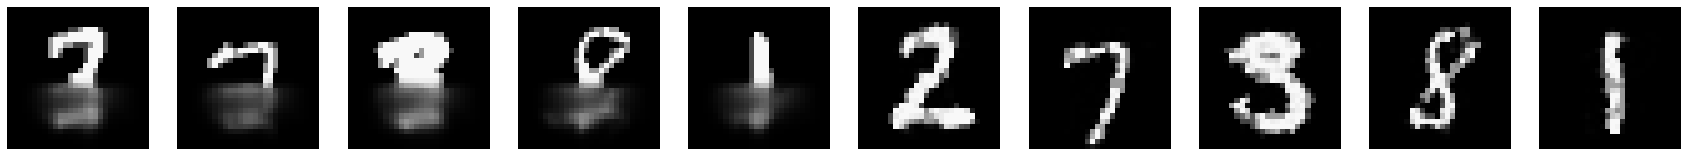

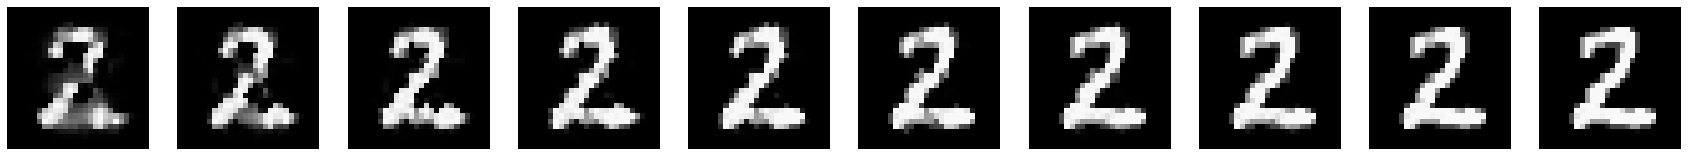

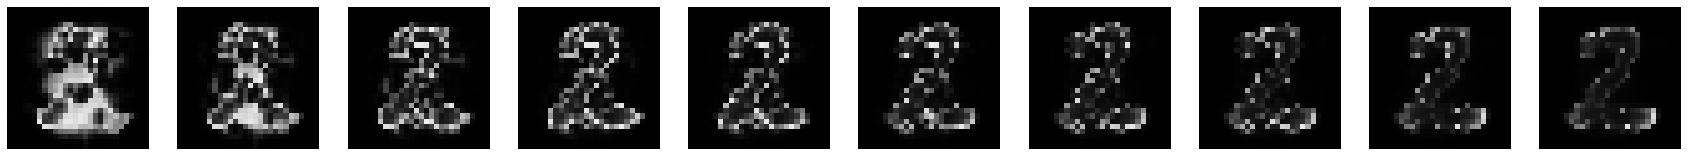

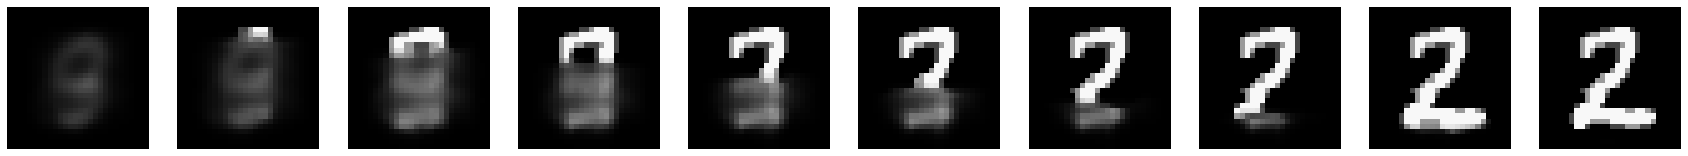

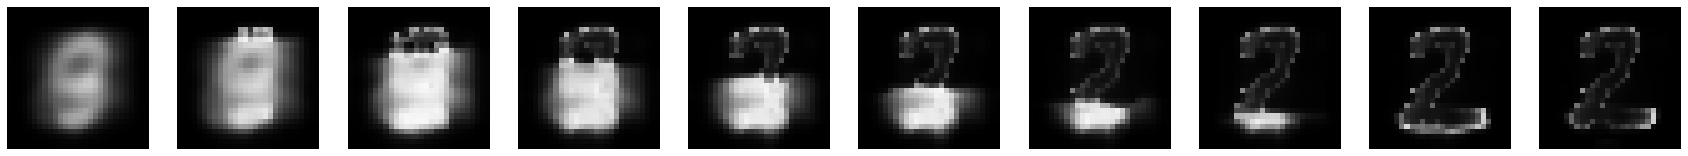

Step 2860, Loss (last minibatch): 0.25304752588272095, Loss (500 step avg.): 0.2643323556153836


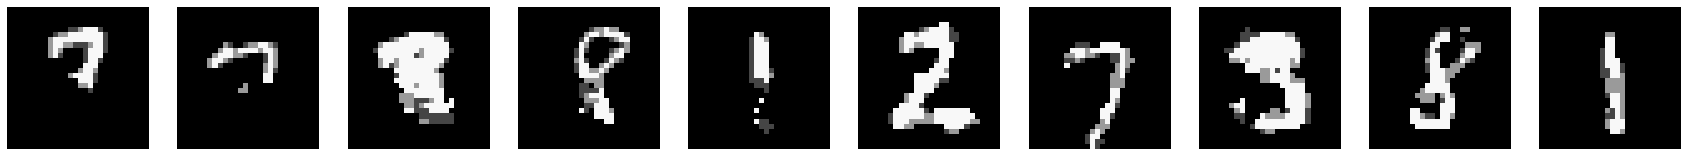

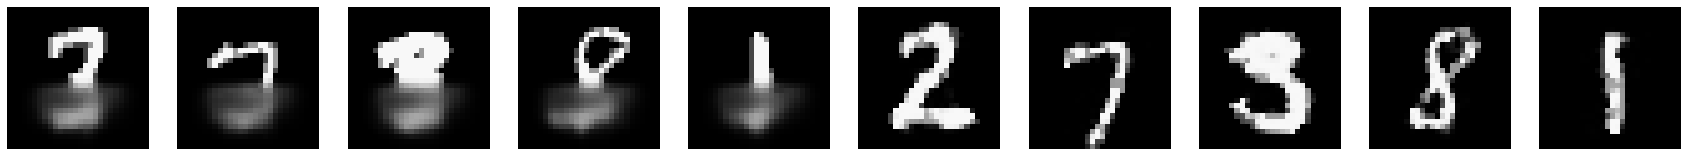

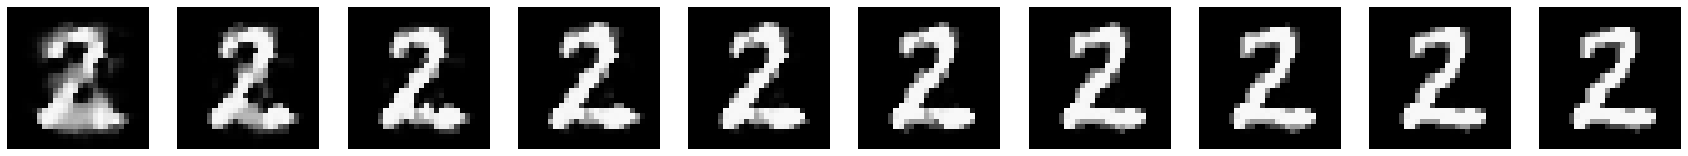

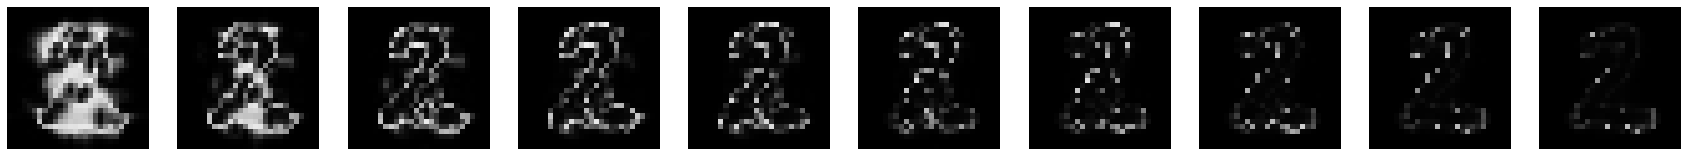

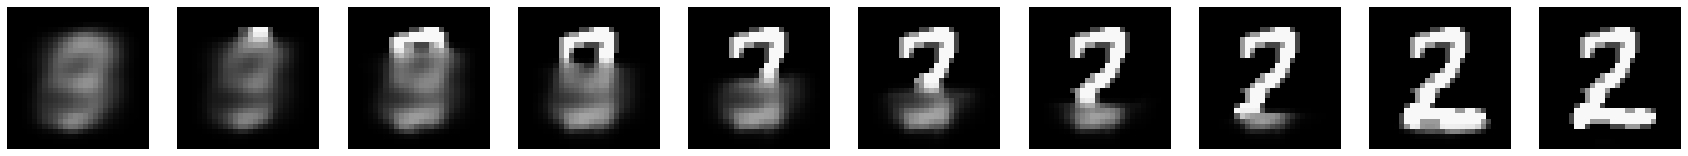

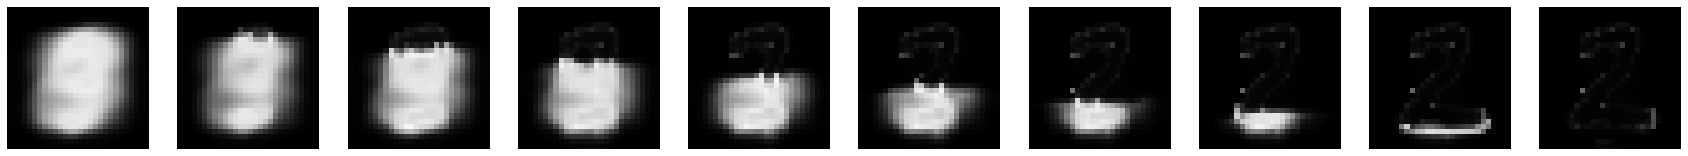

Step 6137, Loss (last minibatch): 0.212464839220047, Loss (500 step avg.): 0.23788699766475999


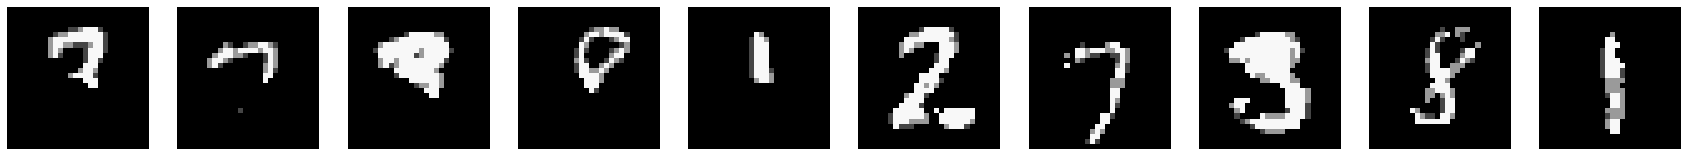

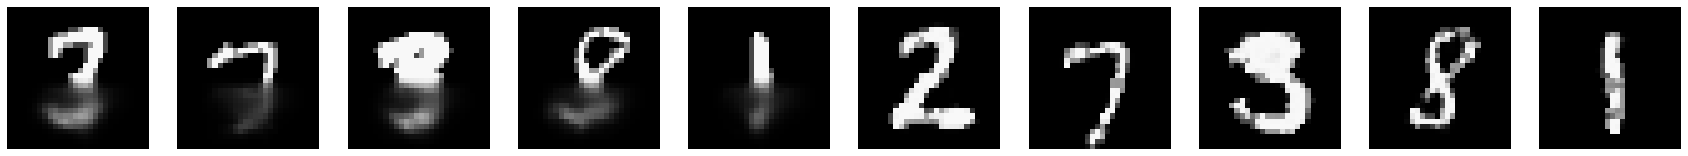

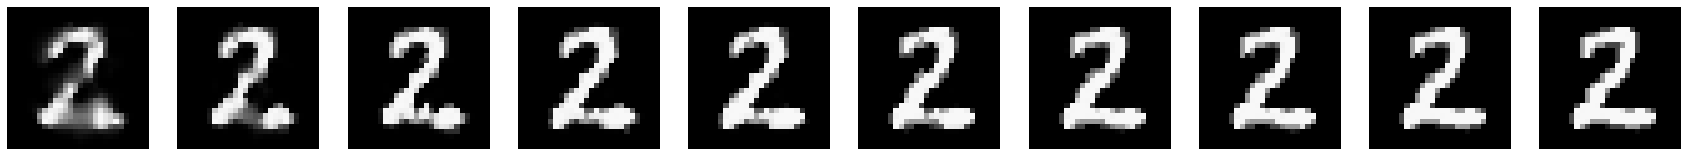

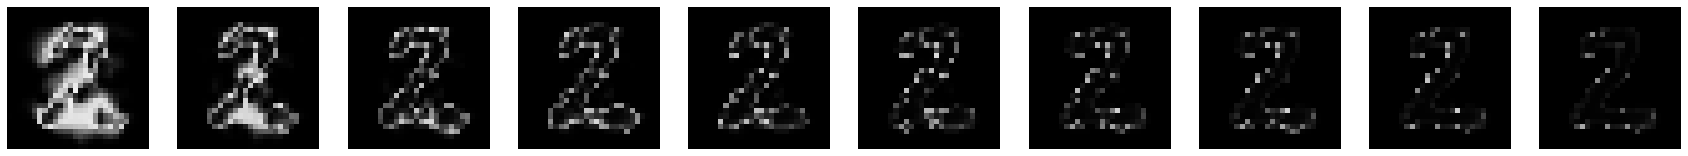

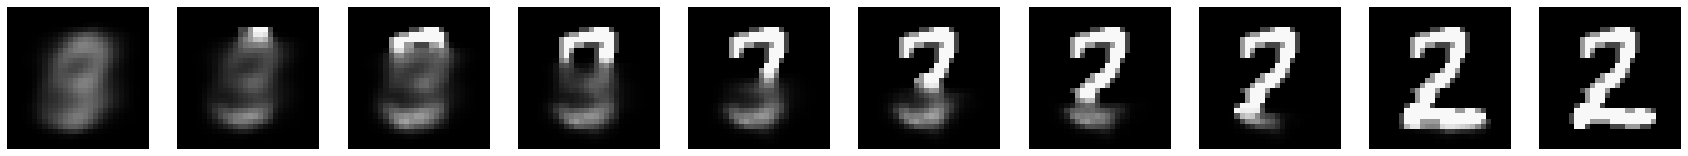

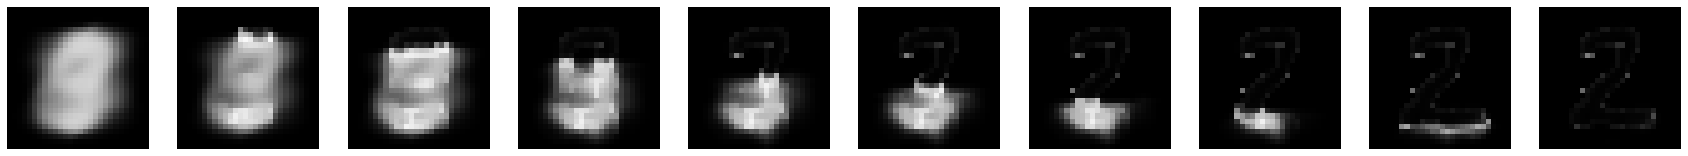

Step 11137, Loss (last minibatch): 0.2076524794101715, Loss (500 step avg.): 0.23359491258205292


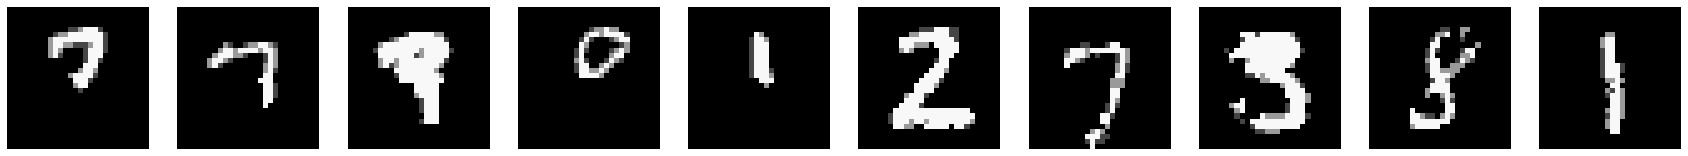

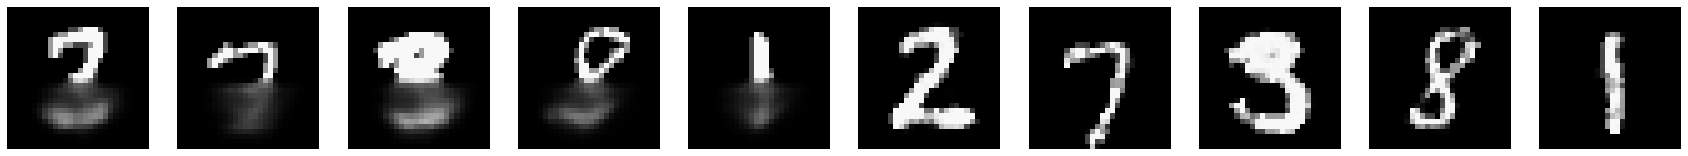

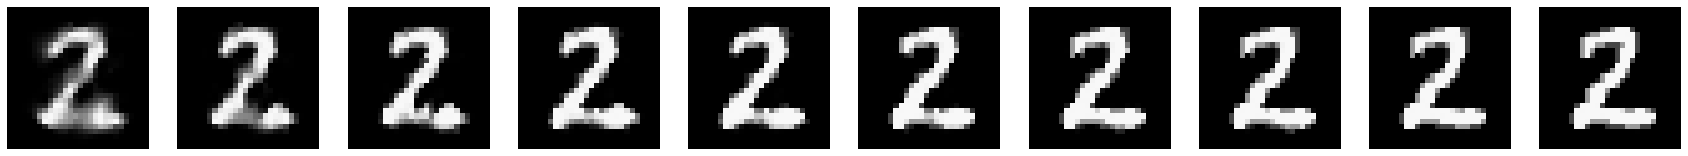

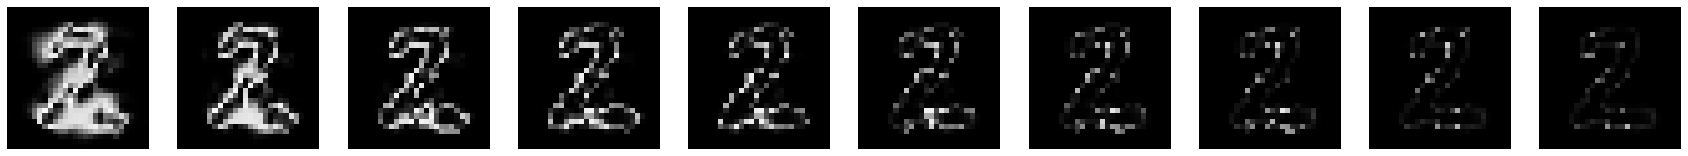

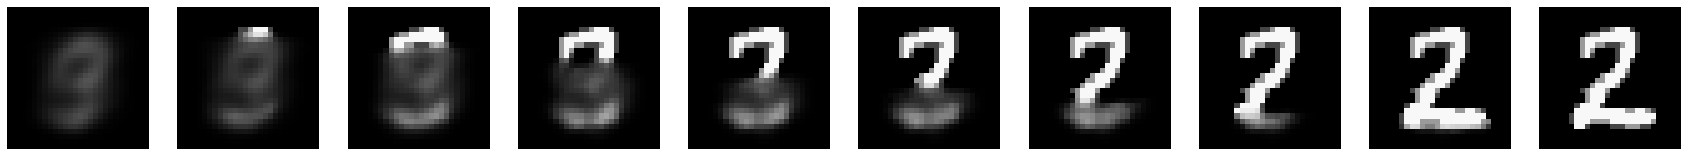

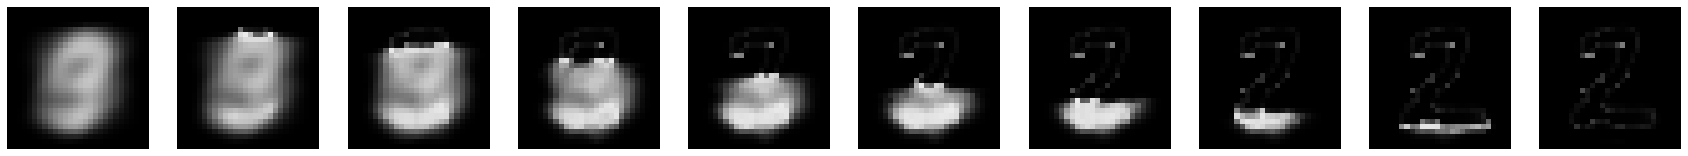

Step 16137, Loss (last minibatch): 0.2688795030117035, Loss (500 step avg.): 0.22792400946160277


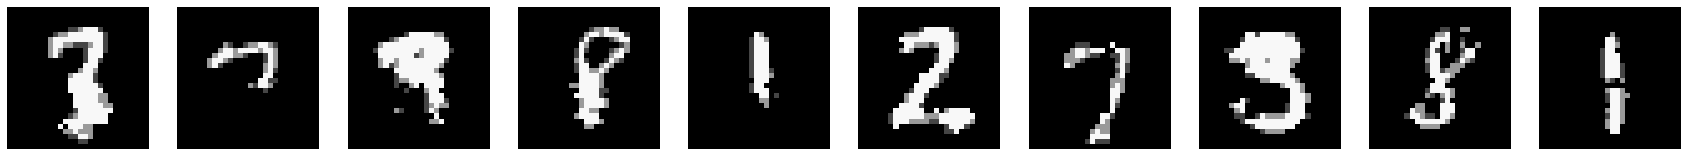

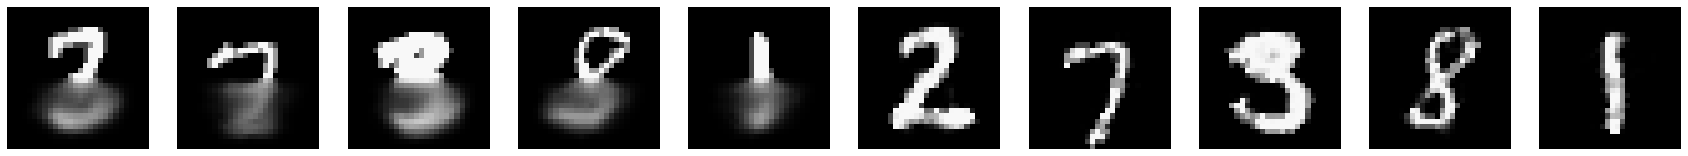

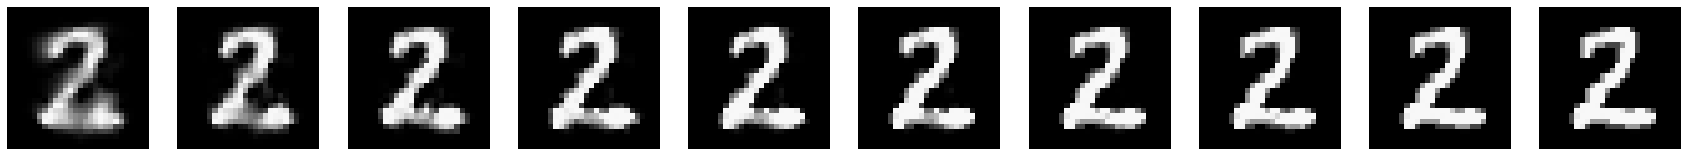

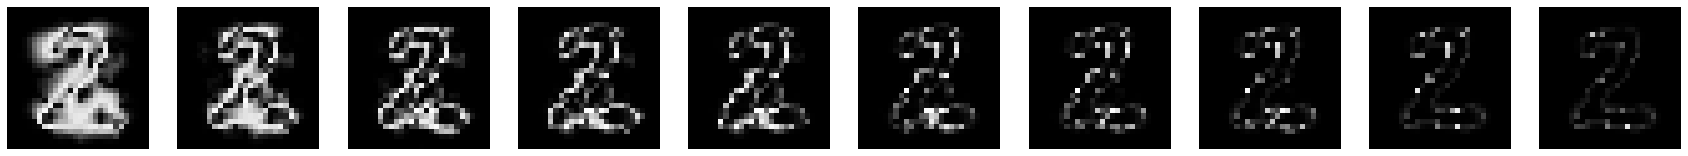

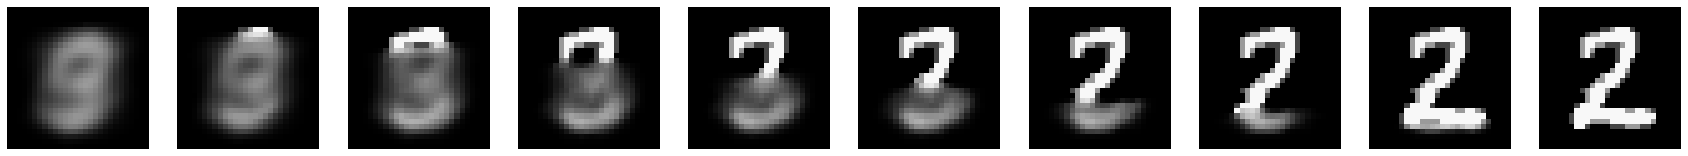

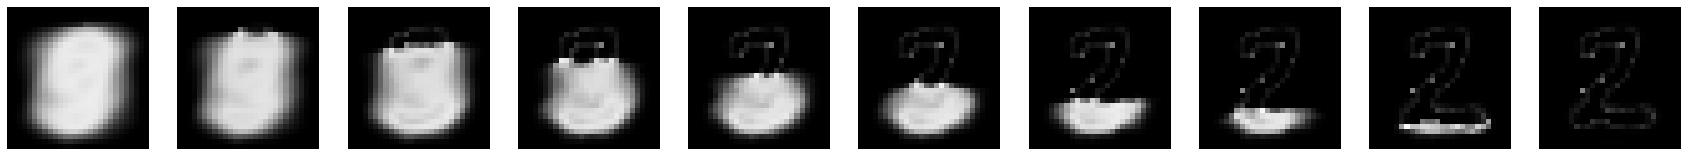

Step 21137, Loss (last minibatch): 0.24060486257076263, Loss (500 step avg.): 0.22694741876539357


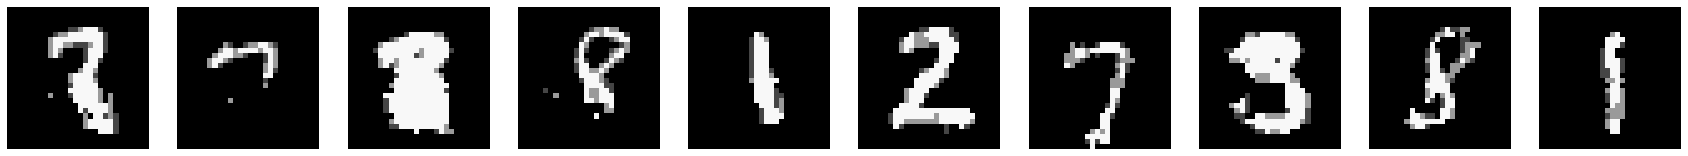

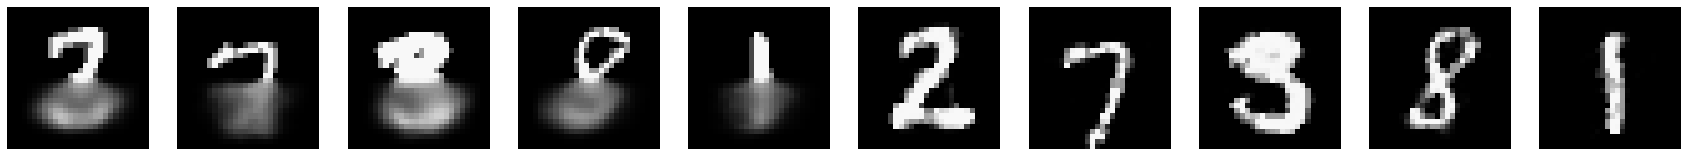

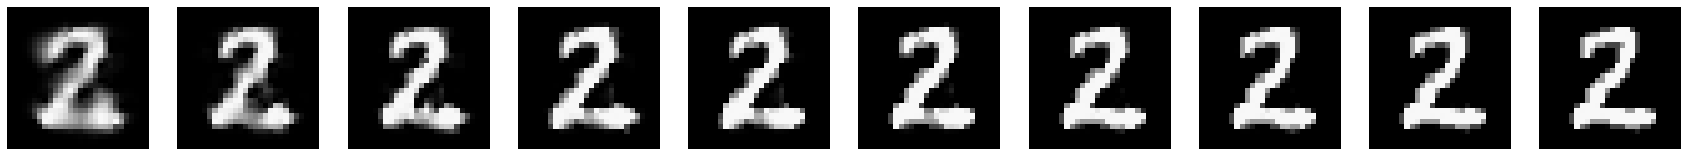

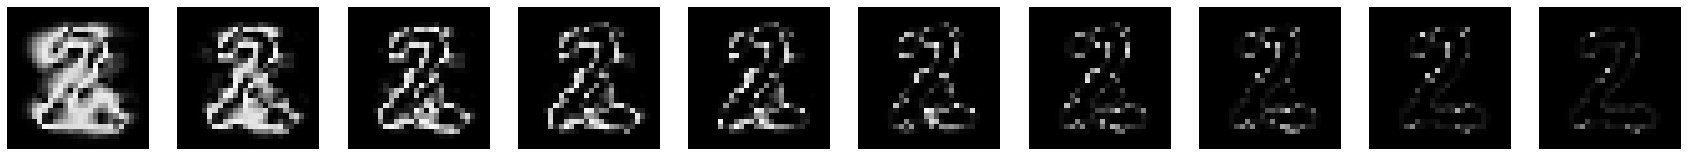

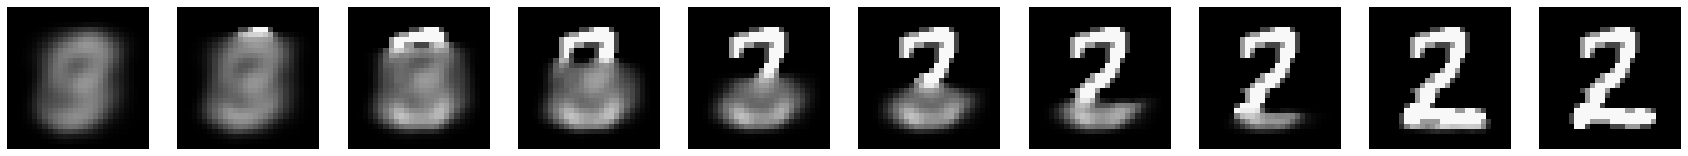

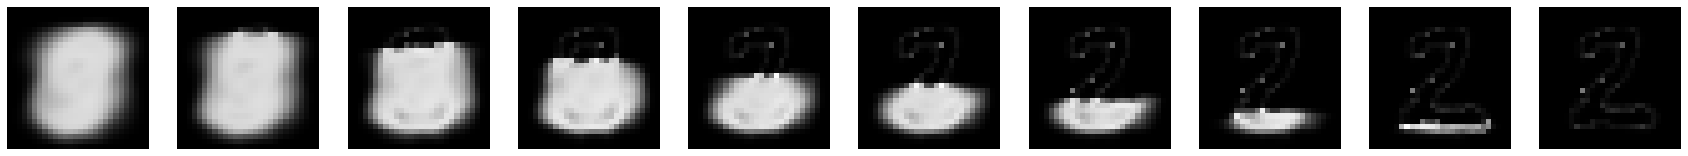

Step 26137, Loss (last minibatch): 0.24538469314575195, Loss (500 step avg.): 0.2260506923148732


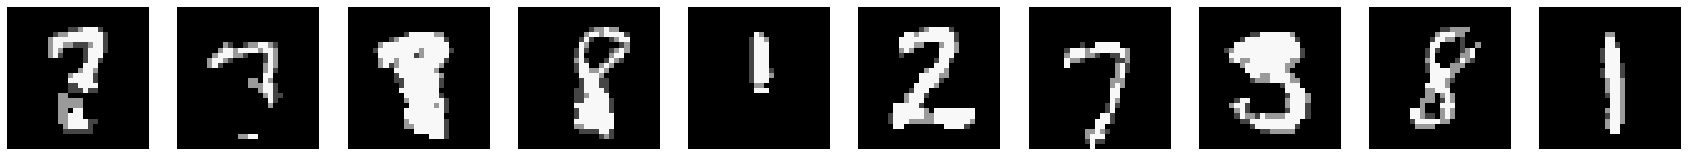

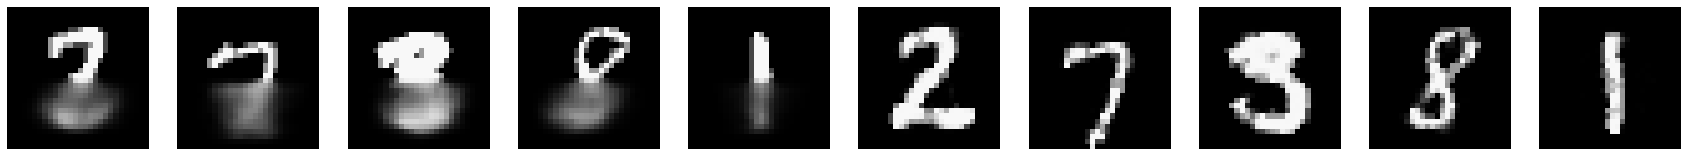

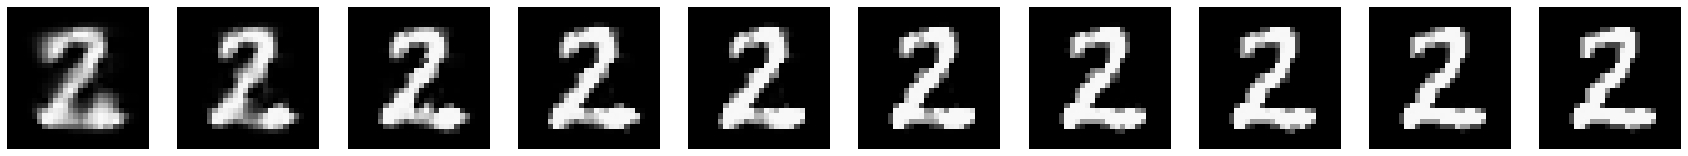

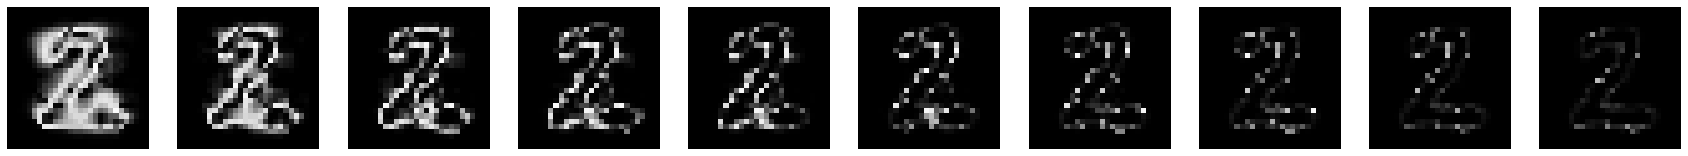

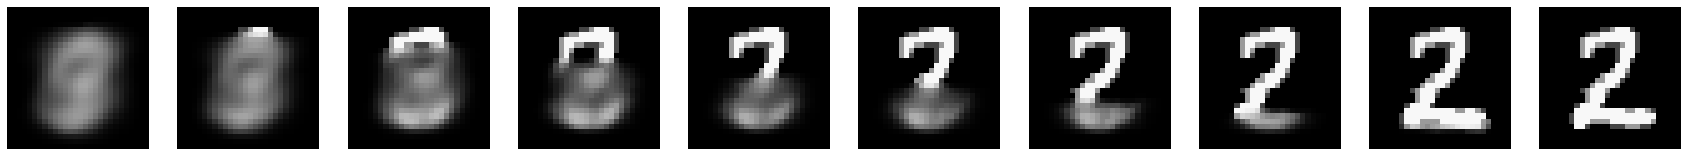

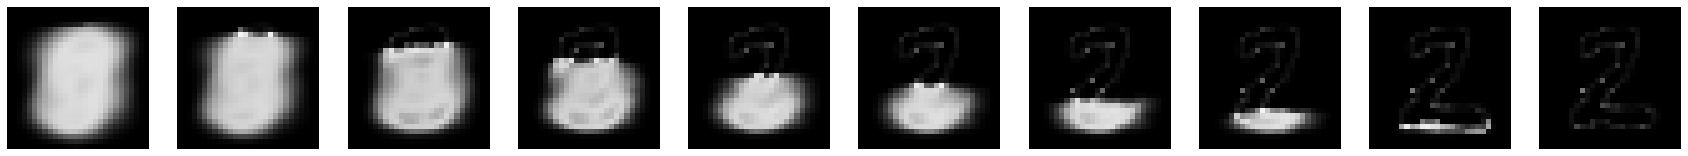

Step 31137, Loss (last minibatch): 0.19859415292739868, Loss (500 step avg.): 0.22411580104194953


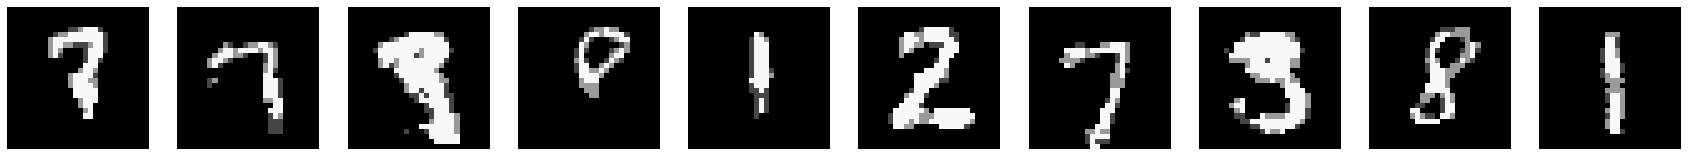

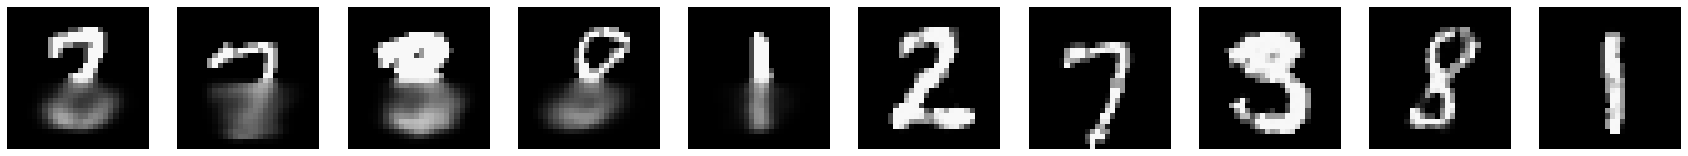

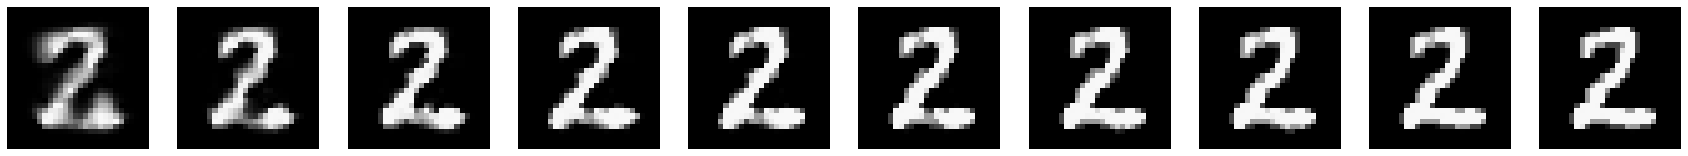

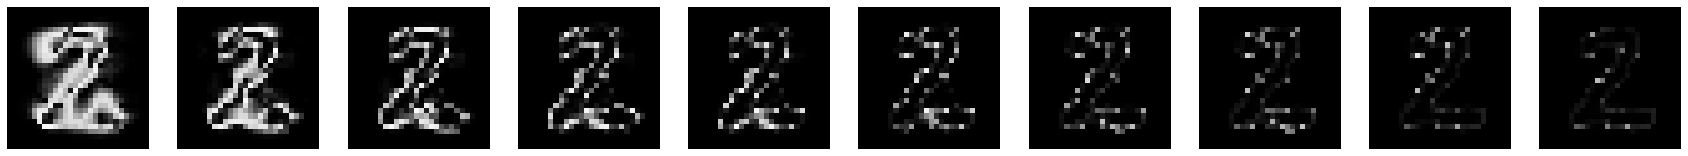

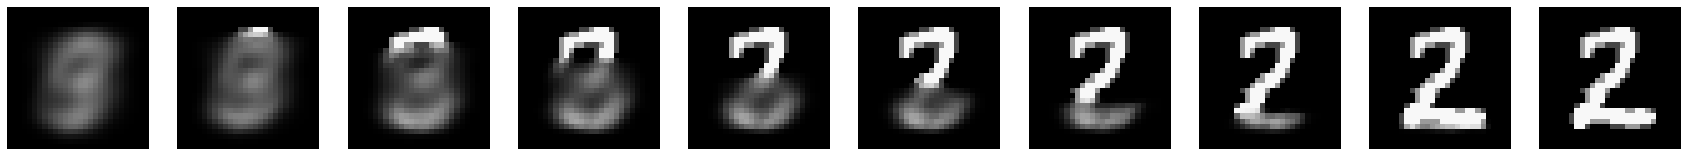

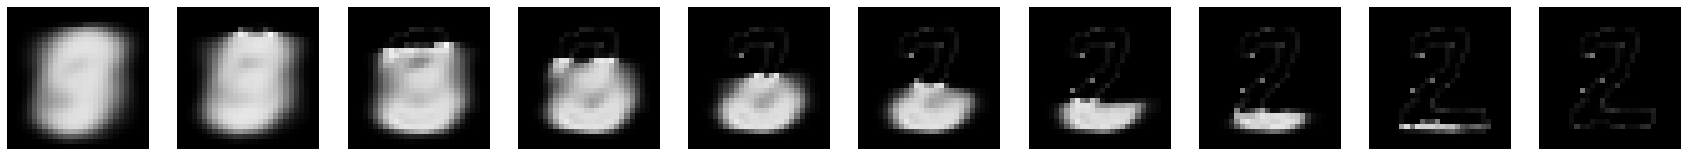

Step 36137, Loss (last minibatch): 0.226307675242424, Loss (500 step avg.): 0.22187250671153536


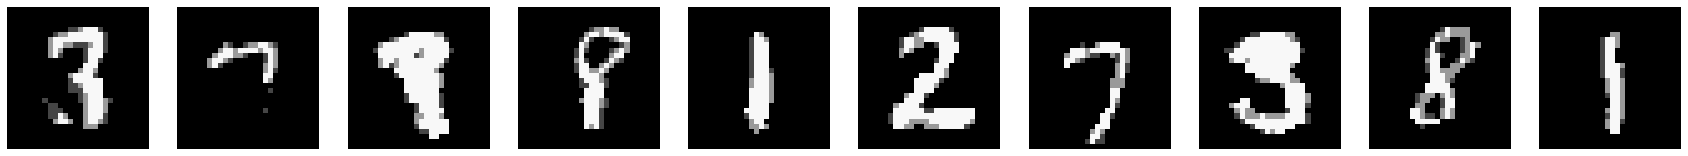

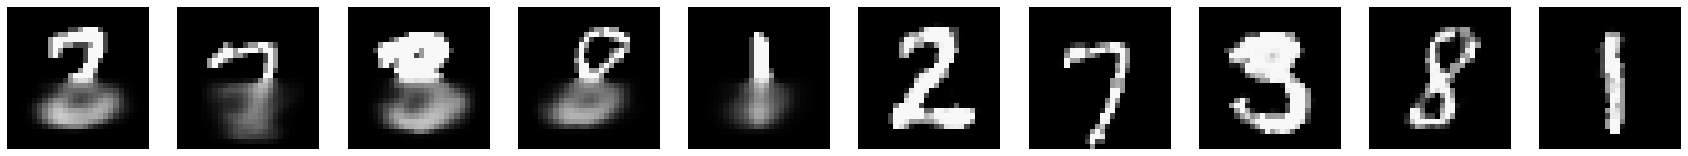

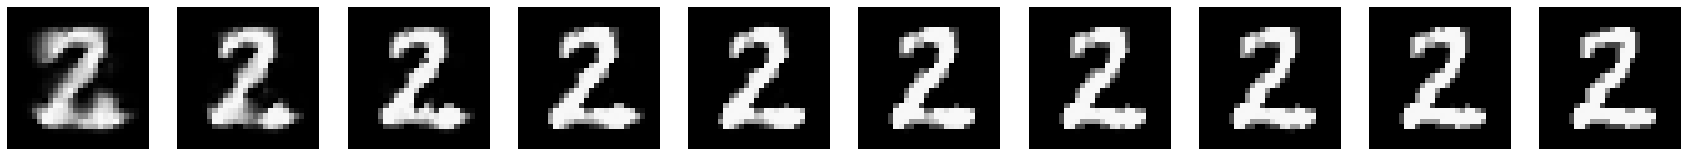

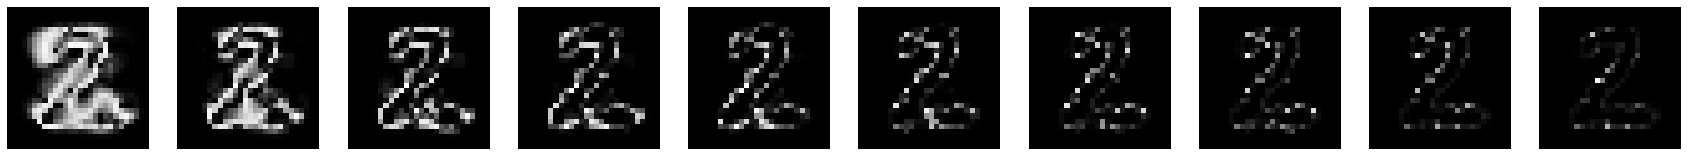

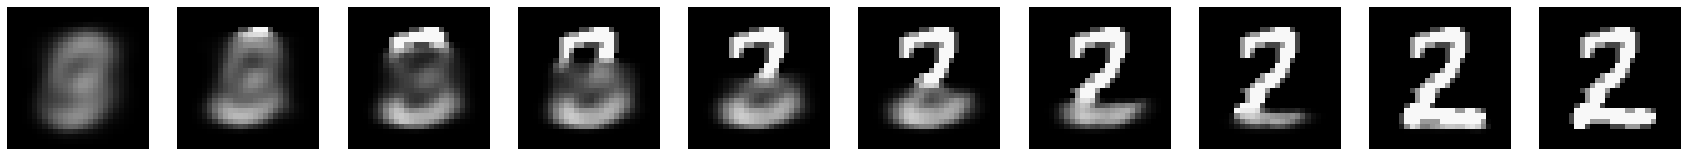

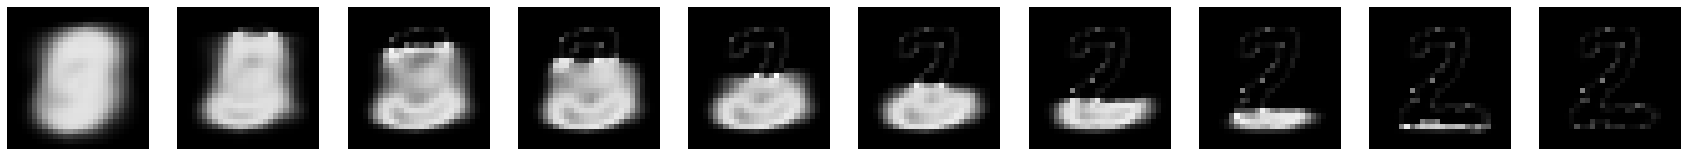

Step 41137, Loss (last minibatch): 0.20778457820415497, Loss (500 step avg.): 0.22296545682790989


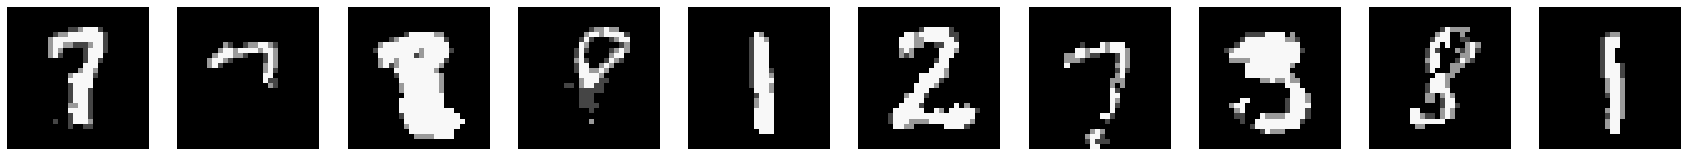

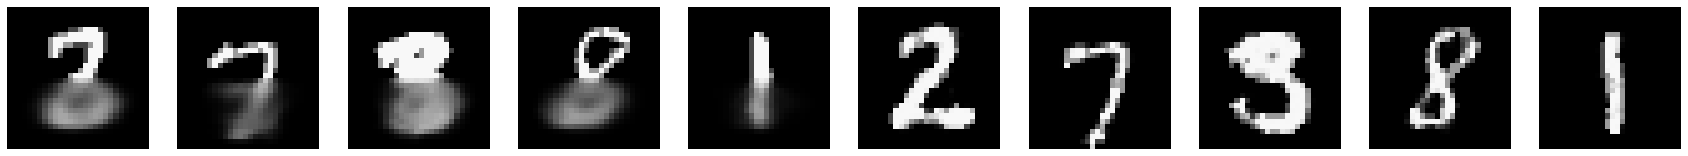

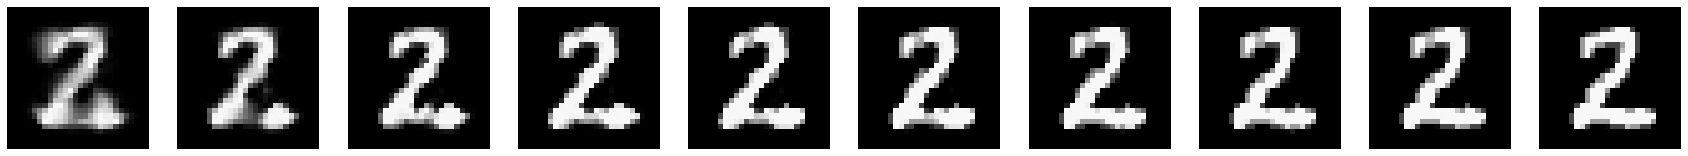

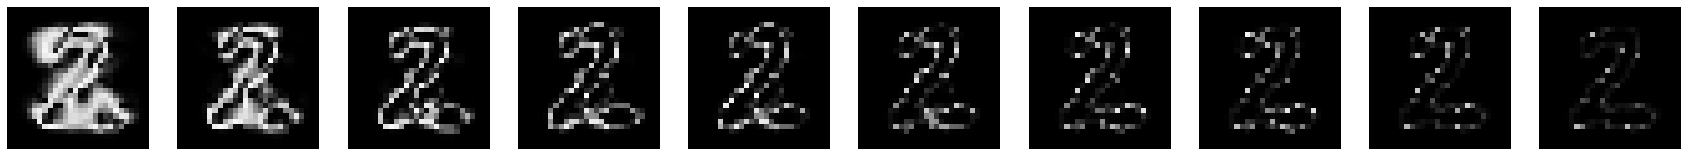

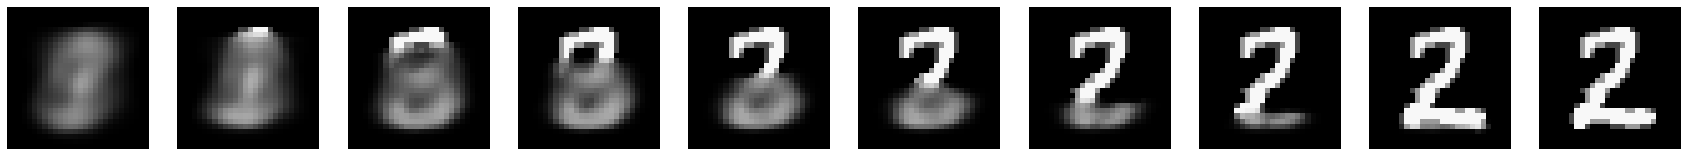

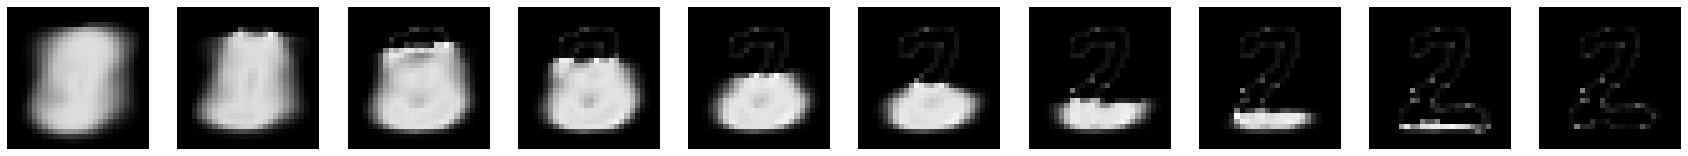

Step 46137, Loss (last minibatch): 0.2551947236061096, Loss (500 step avg.): 0.22055528712962677


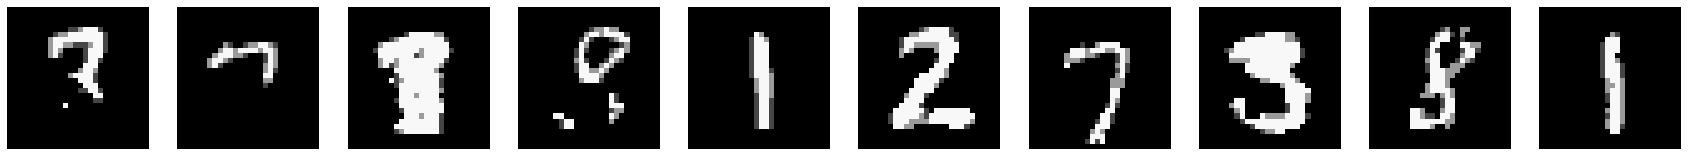

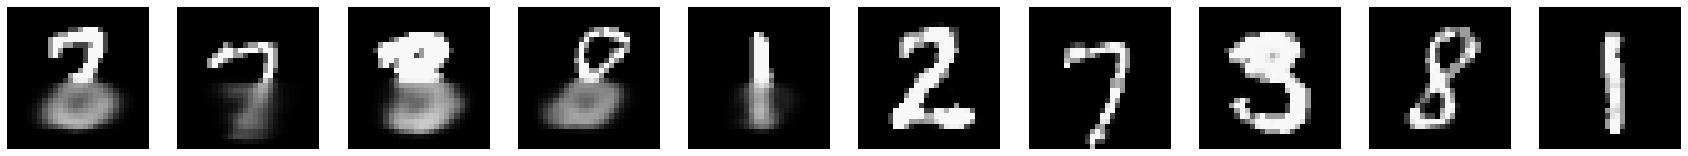

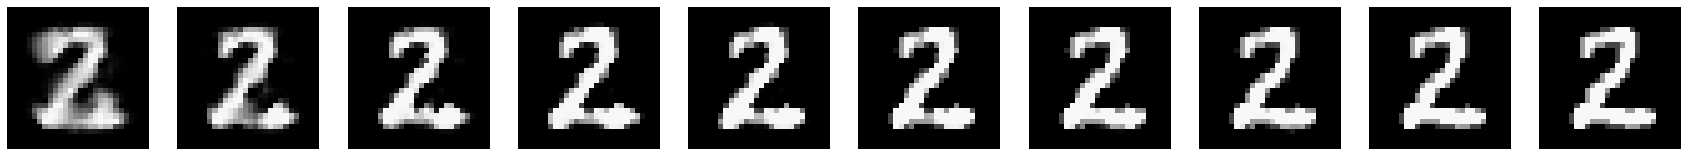

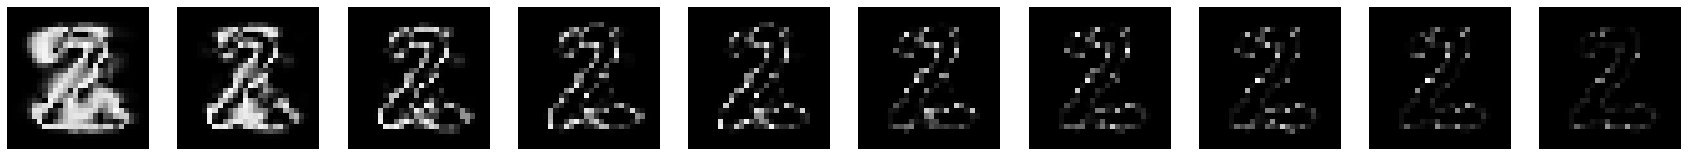

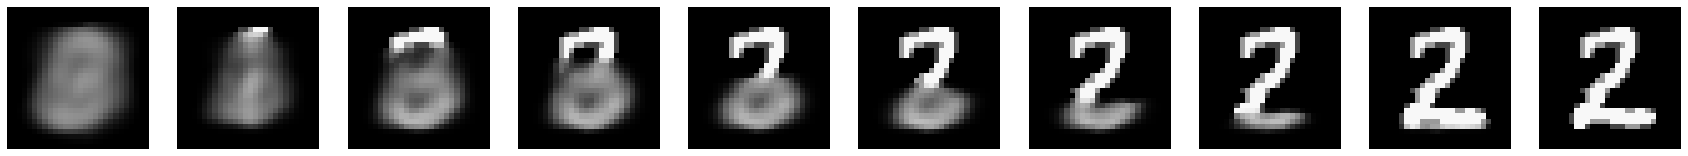

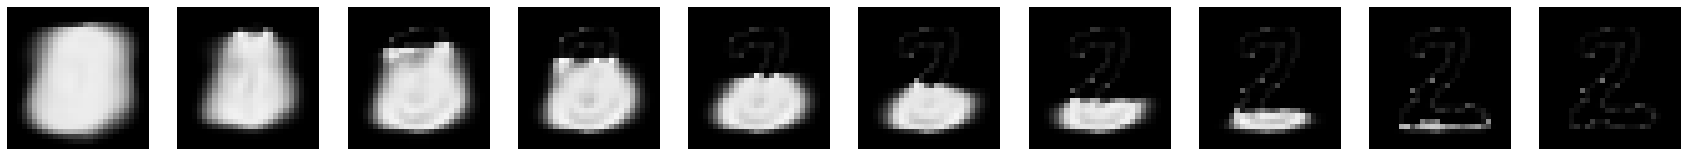

Step 51137, Loss (last minibatch): 0.22582897543907166, Loss (500 step avg.): 0.2204030477655624


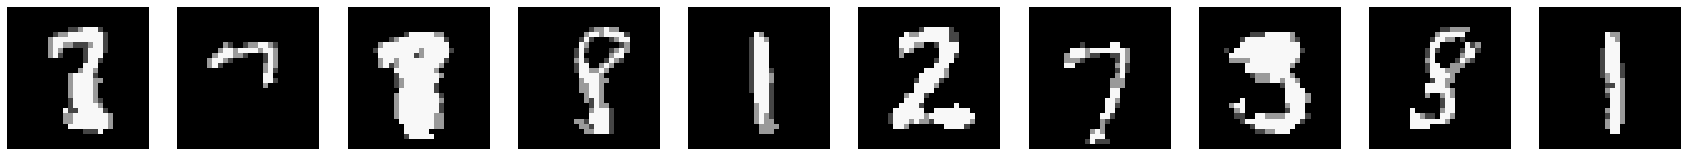

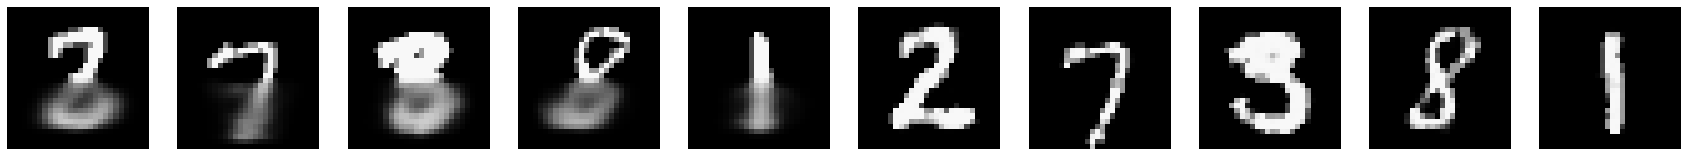

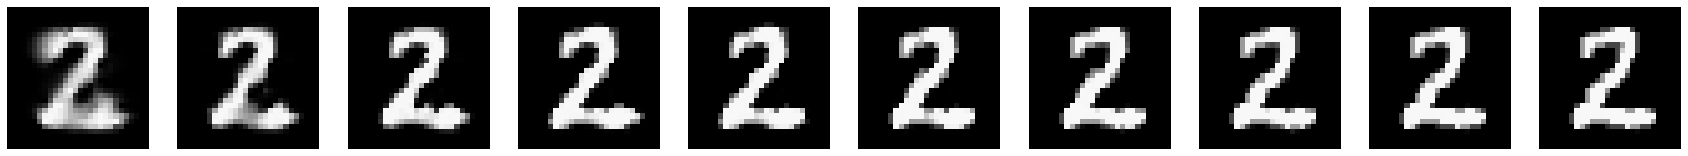

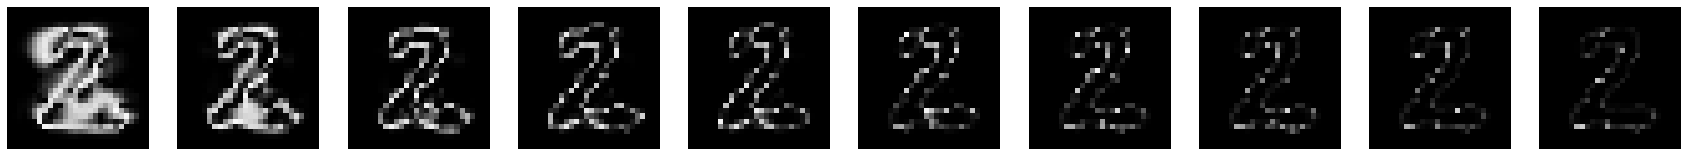

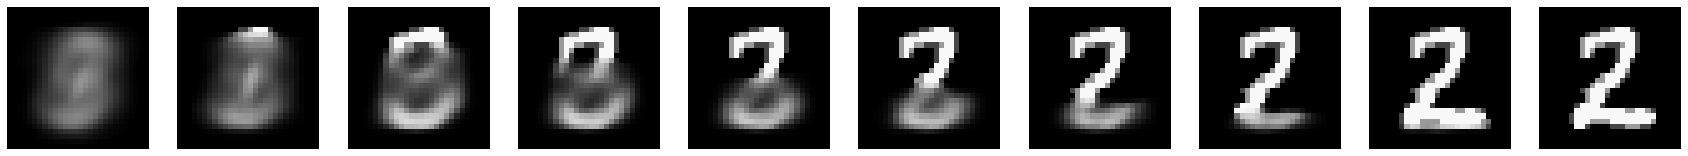

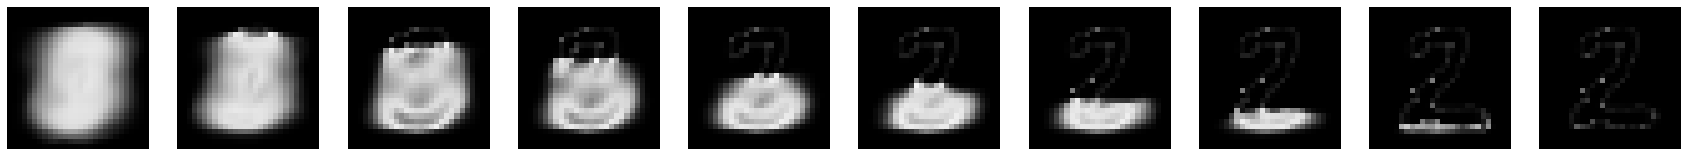

Step 56137, Loss (last minibatch): 0.2376405894756317, Loss (500 step avg.): 0.21887970577456994


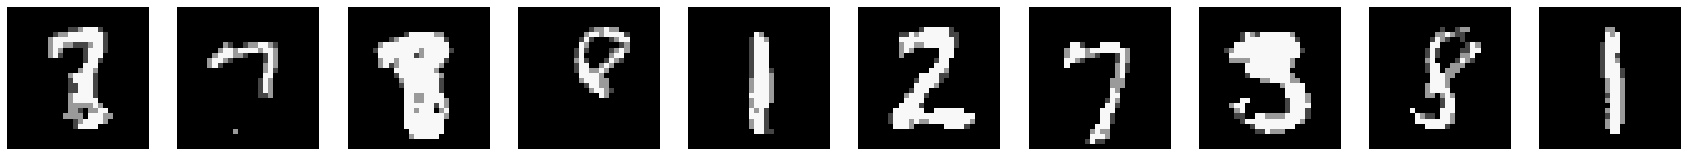

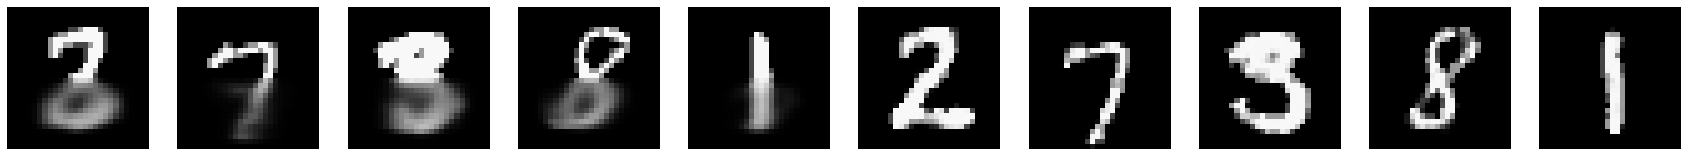

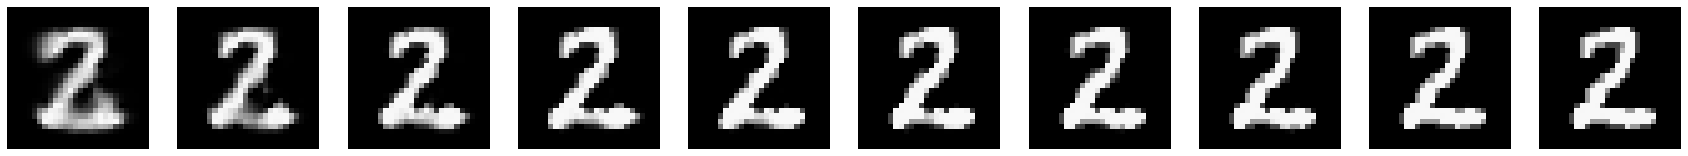

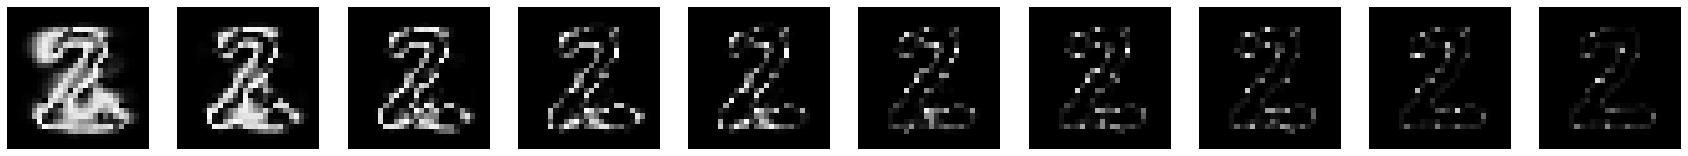

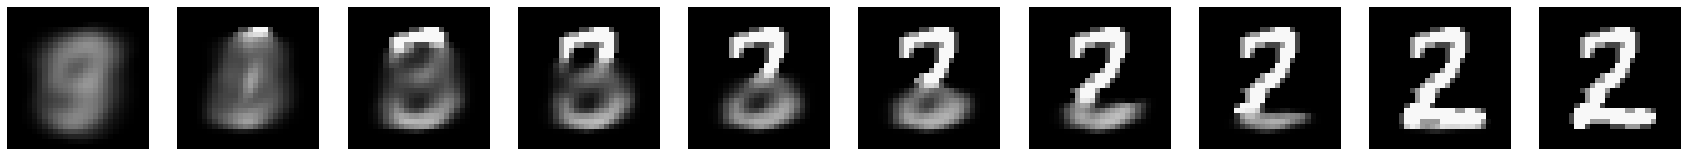

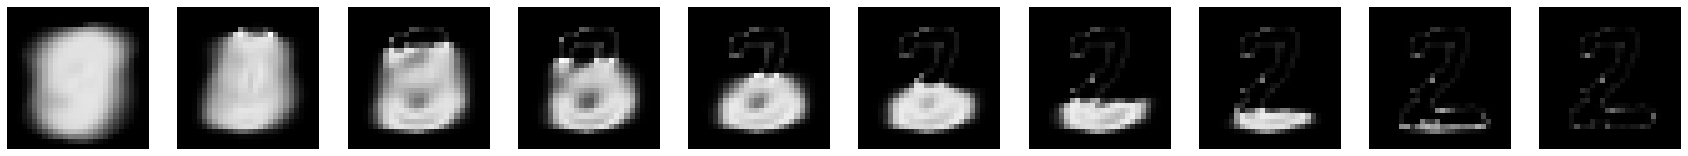

Step 61137, Loss (last minibatch): 0.23410974442958832, Loss (500 step avg.): 0.21792898046042392


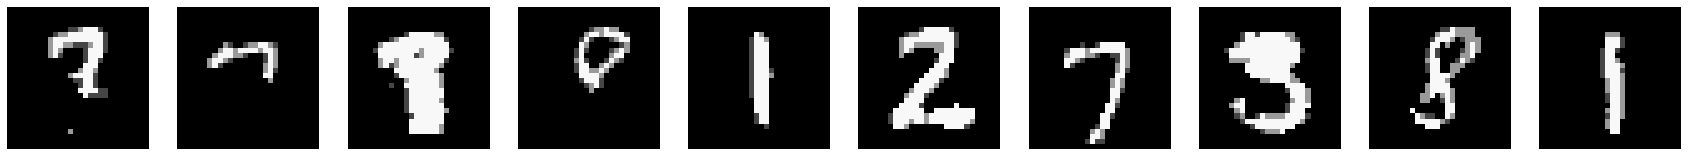

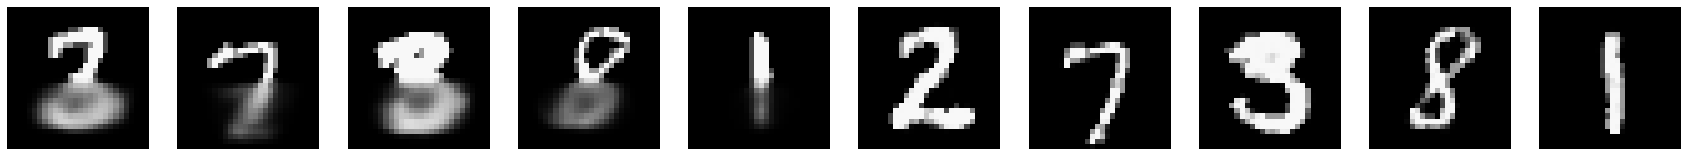

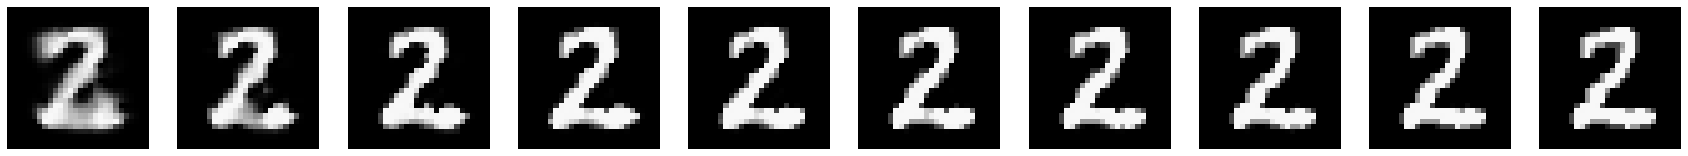

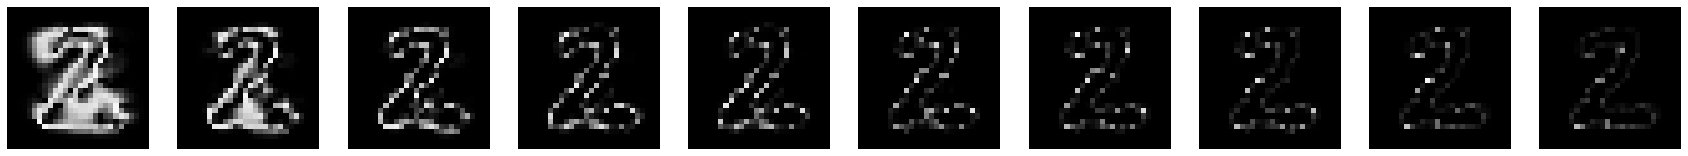

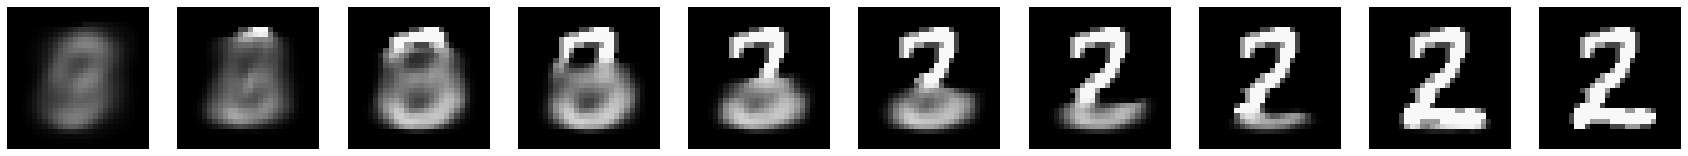

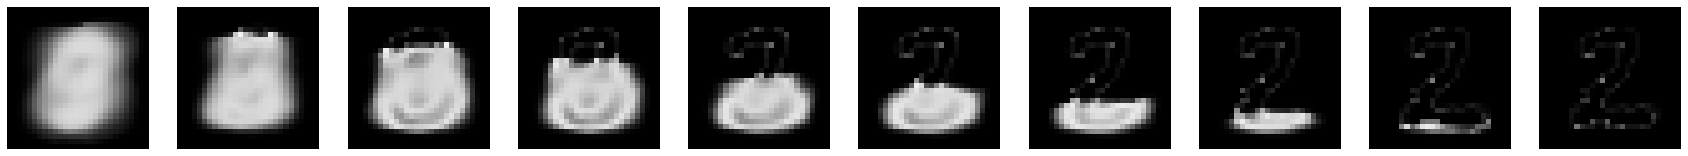

Step 66137, Loss (last minibatch): 0.22478675842285156, Loss (500 step avg.): 0.2169702034926938


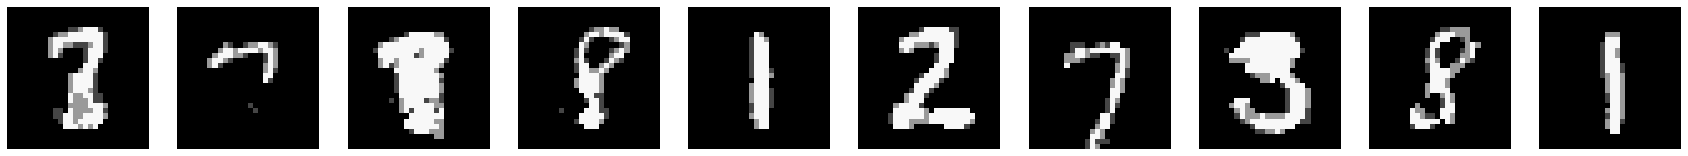

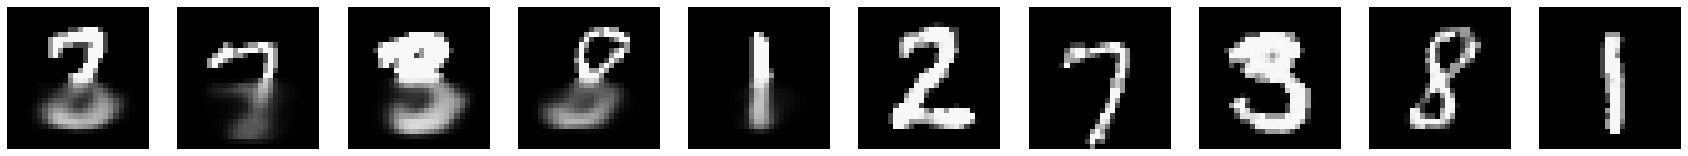

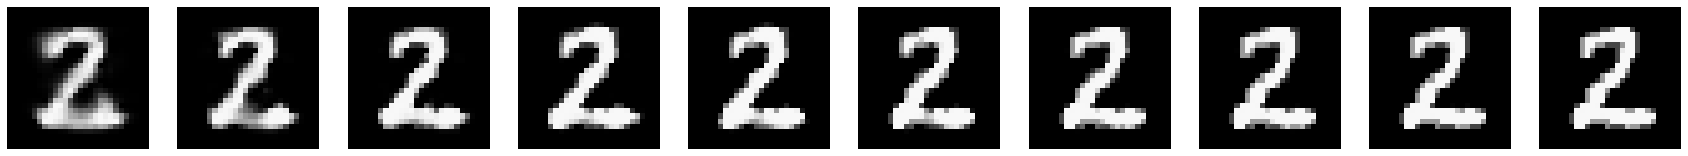

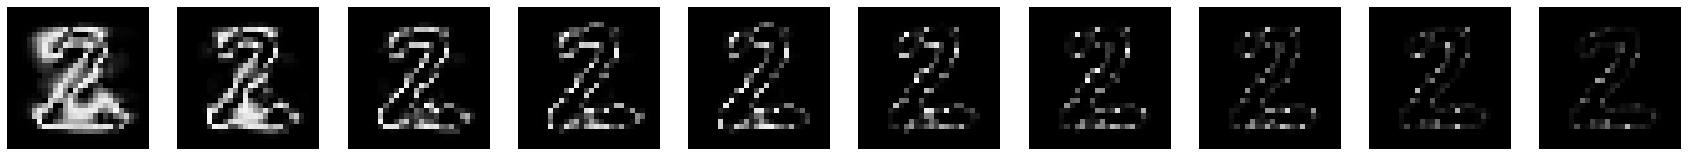

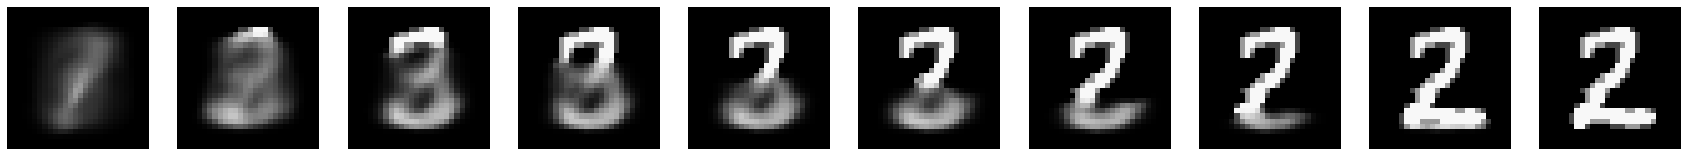

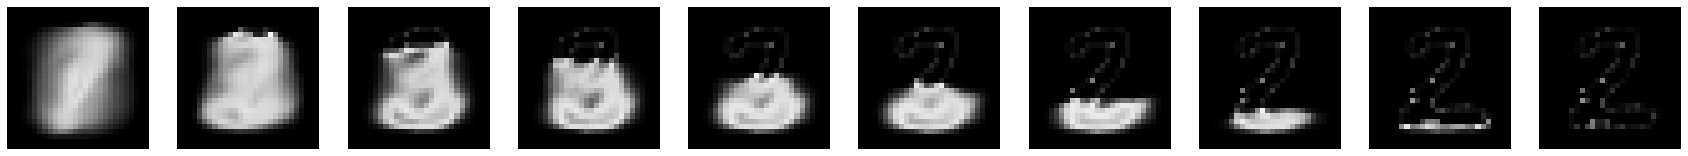

Step 71137, Loss (last minibatch): 0.22467271983623505, Loss (500 step avg.): 0.21698352224574594


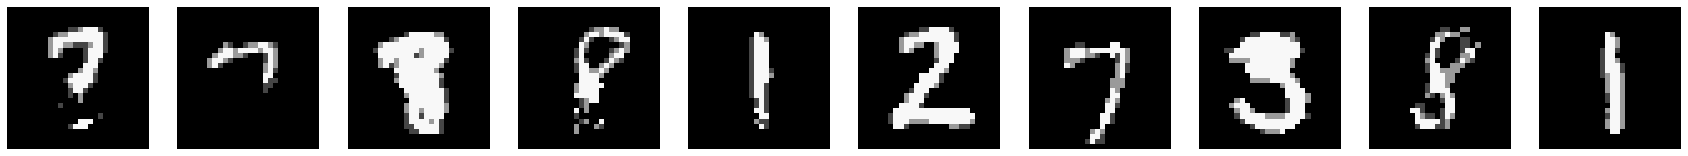

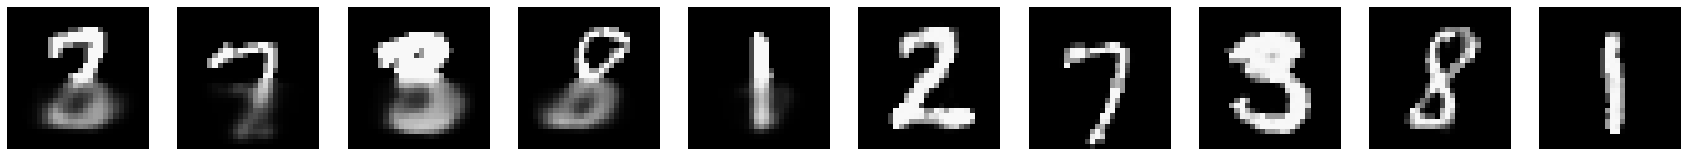

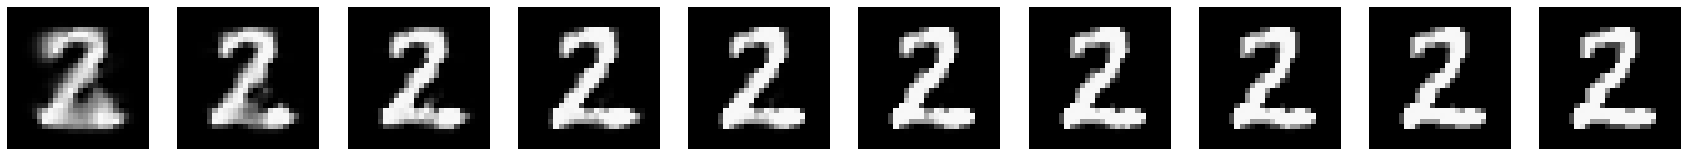

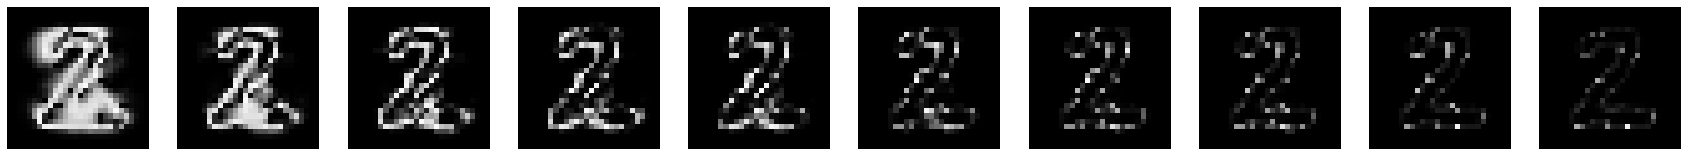

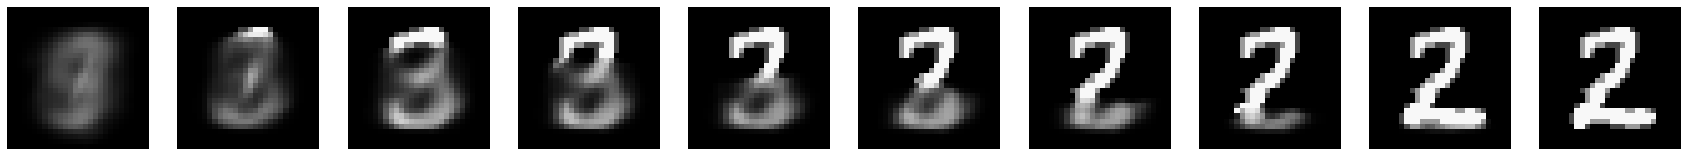

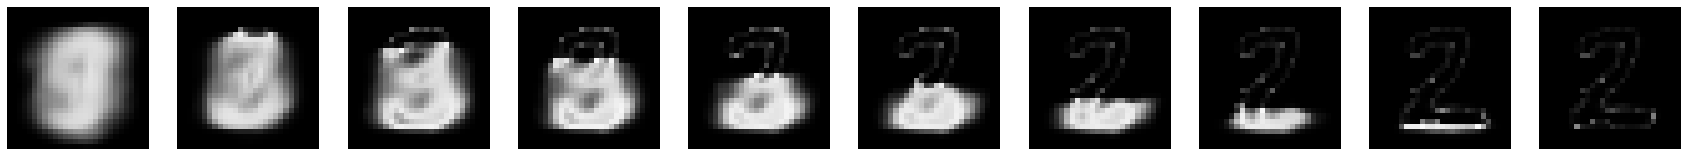

Step 76137, Loss (last minibatch): 0.2200423926115036, Loss (500 step avg.): 0.2173345973510704


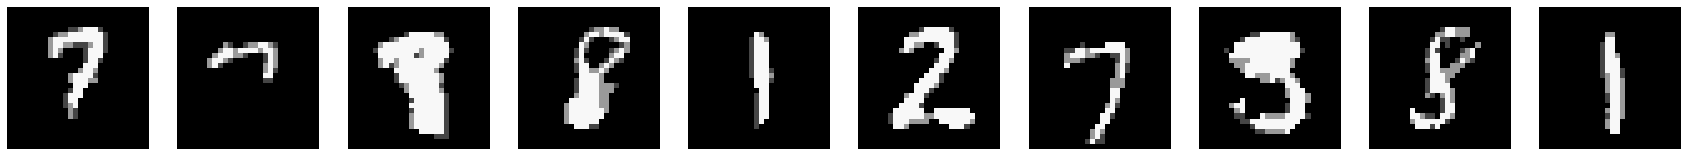

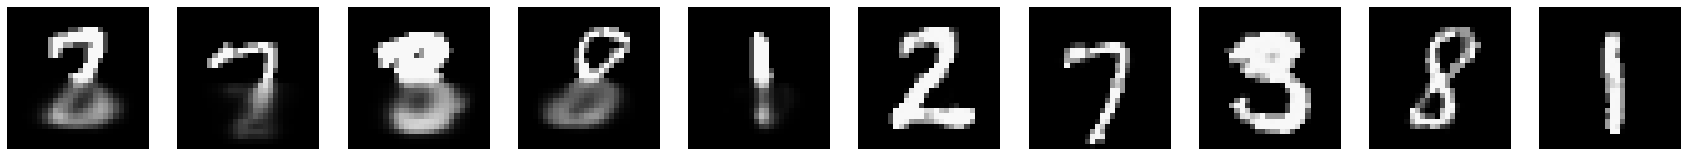

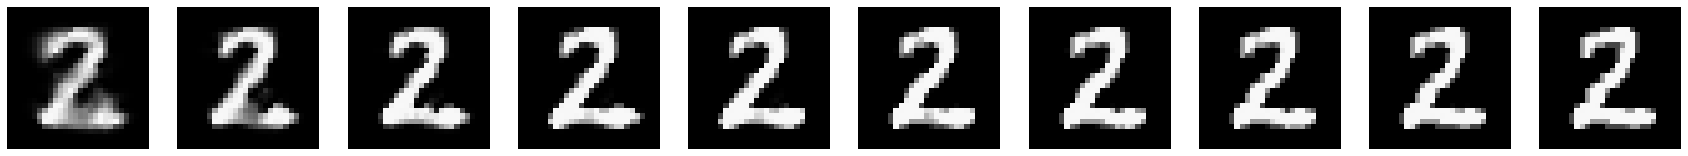

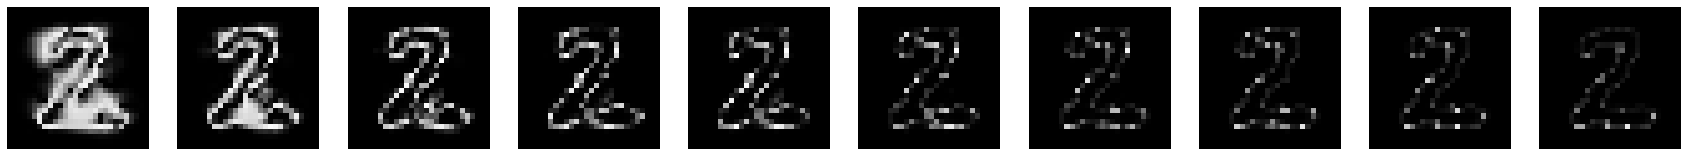

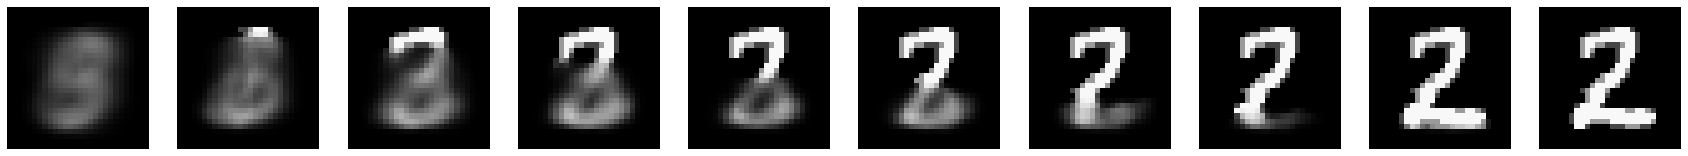

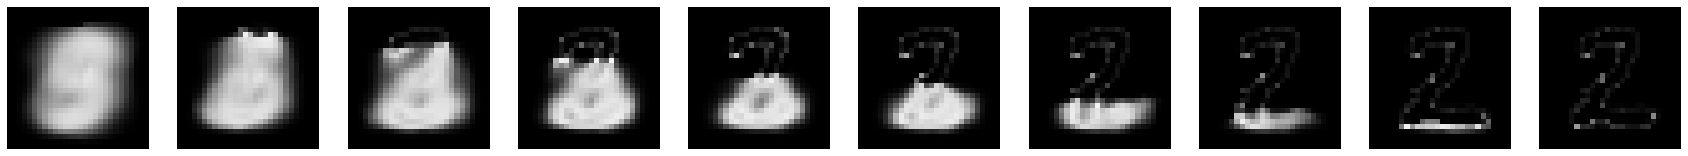

Step 81137, Loss (last minibatch): 0.21299698948860168, Loss (500 step avg.): 0.21586493894963446


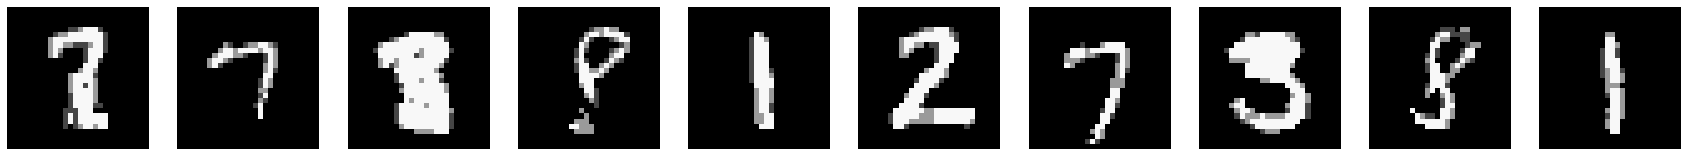

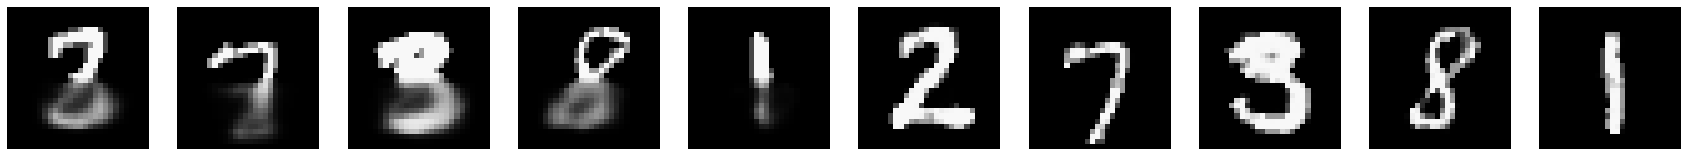

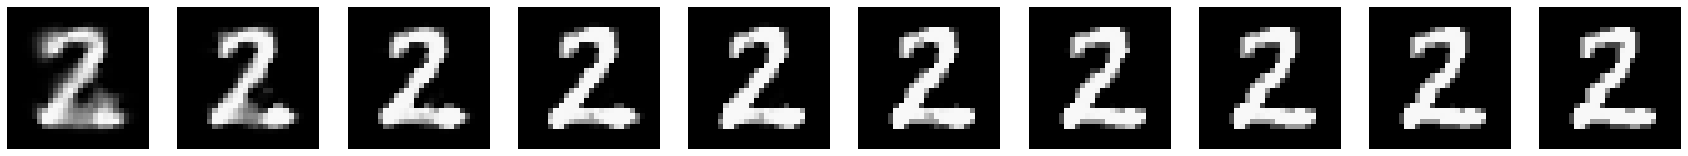

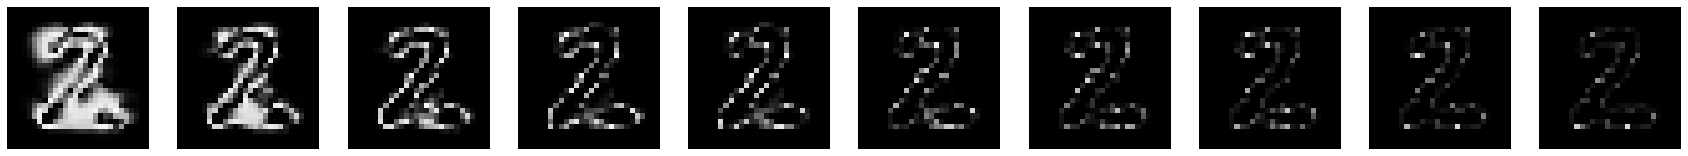

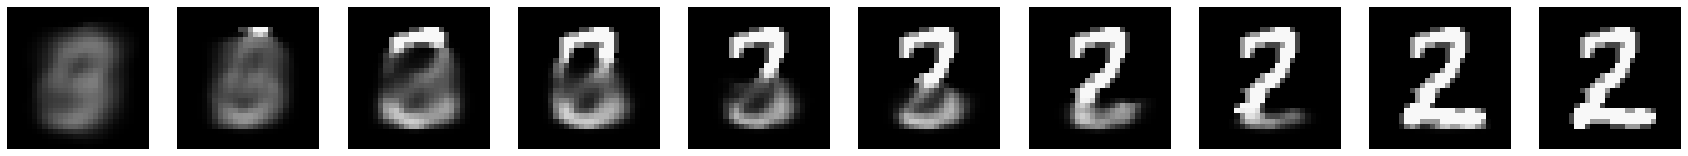

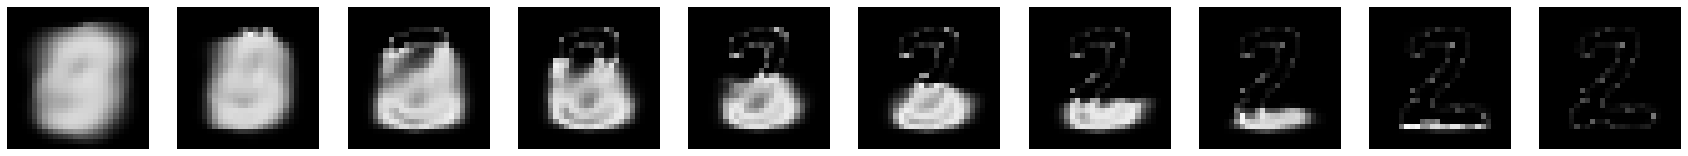

Step 86137, Loss (last minibatch): 0.18987588584423065, Loss (500 step avg.): 0.21523029022587986


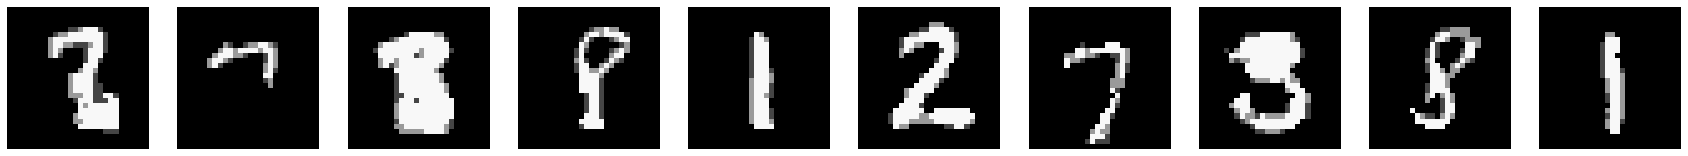

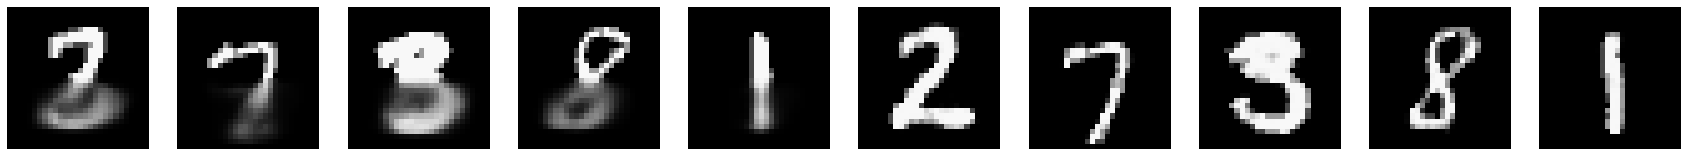

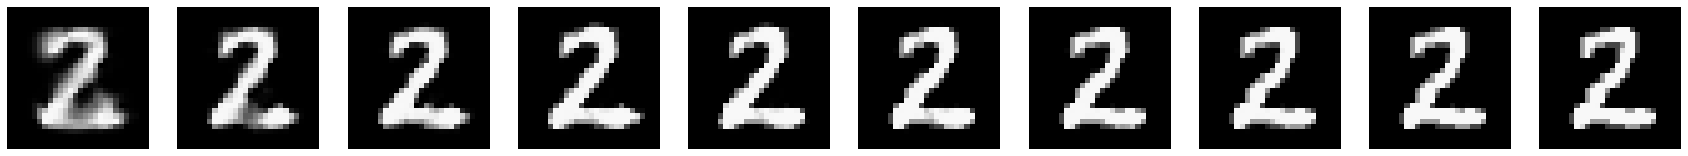

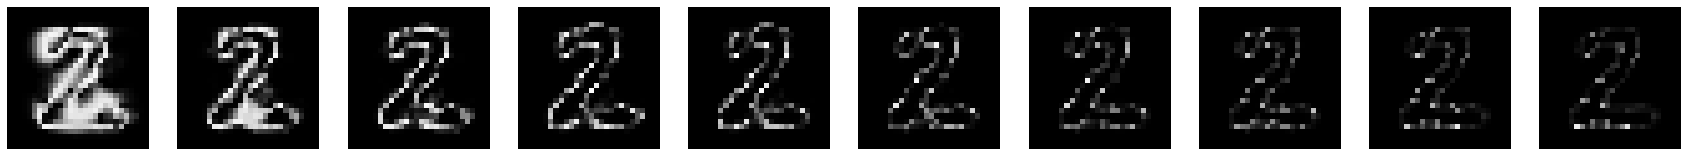

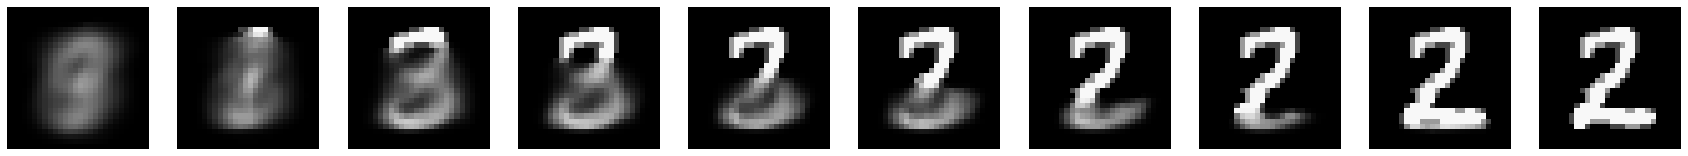

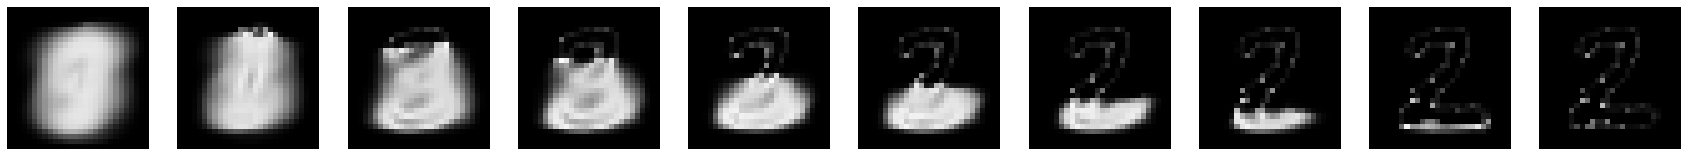

Step 91137, Loss (last minibatch): 0.1879897117614746, Loss (500 step avg.): 0.21445806372070503


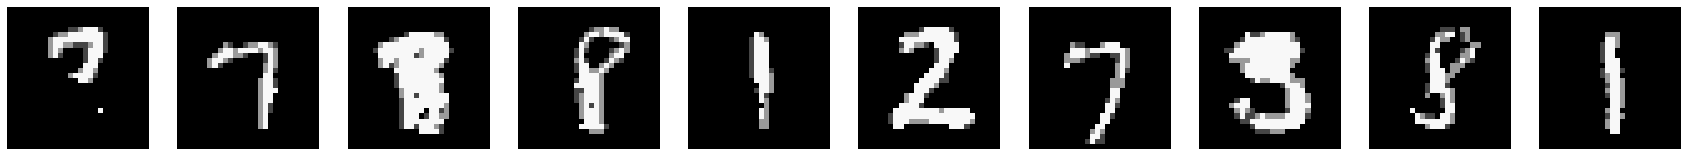

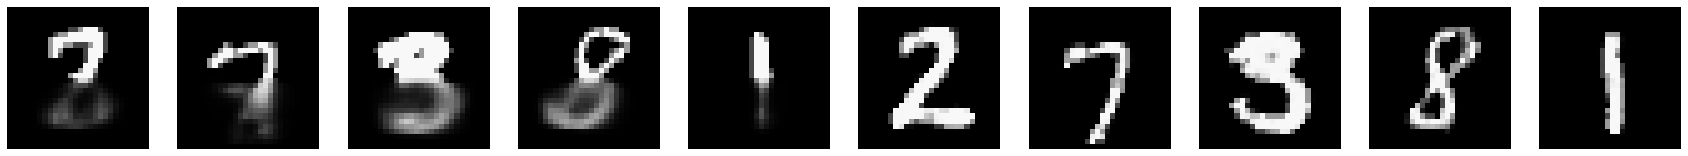

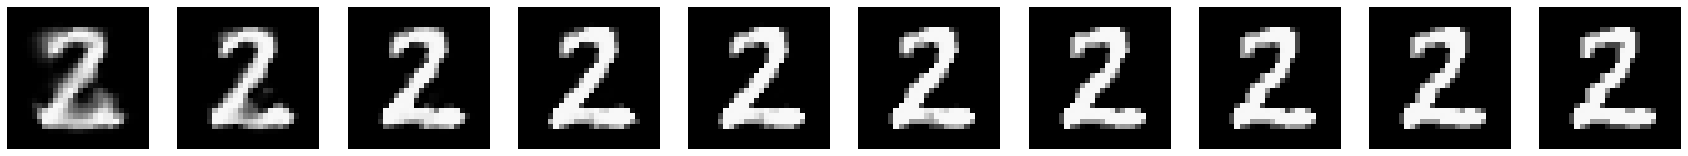

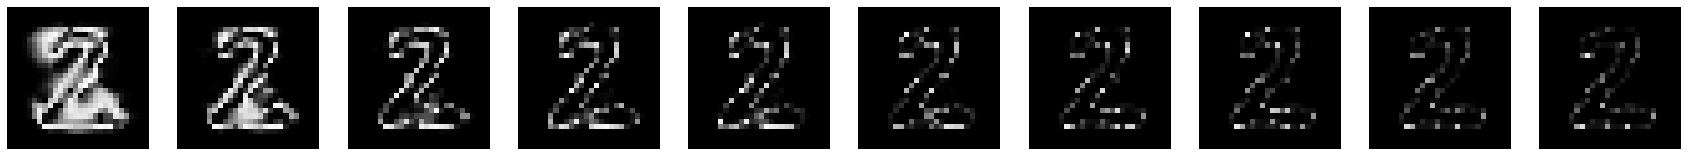

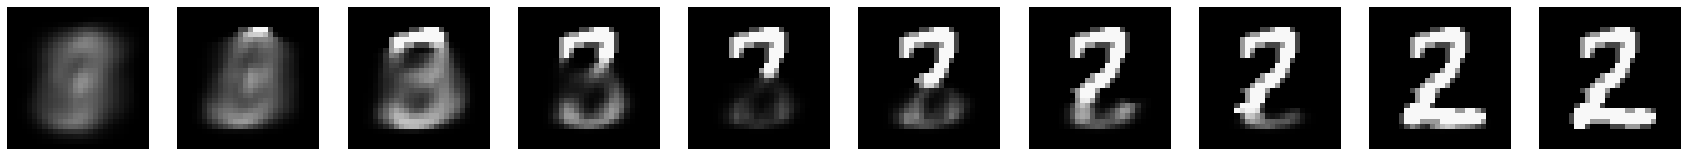

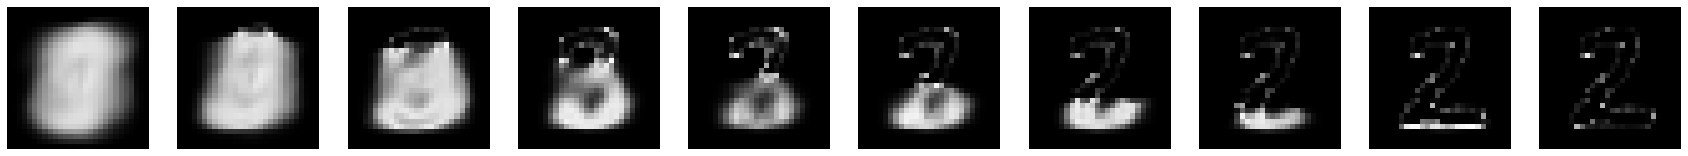

Step 96137, Loss (last minibatch): 0.2294001430273056, Loss (500 step avg.): 0.21363309335089967


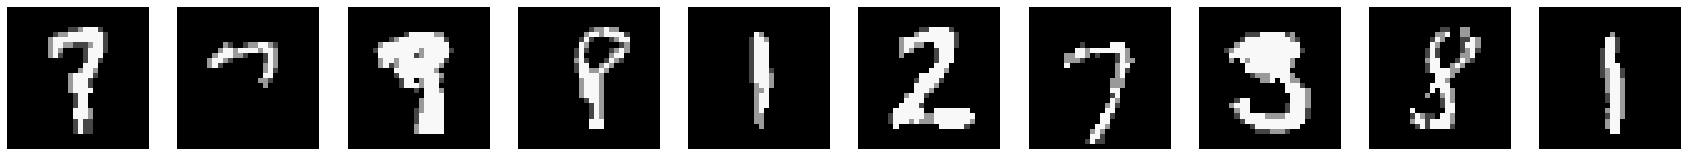

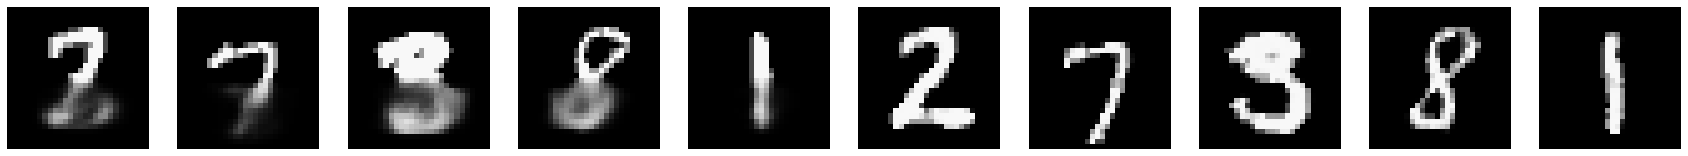

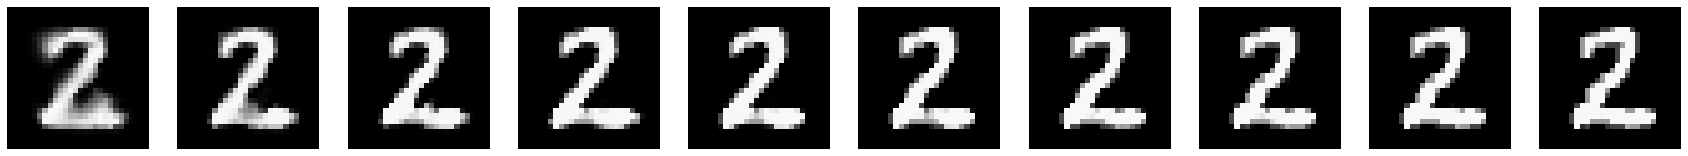

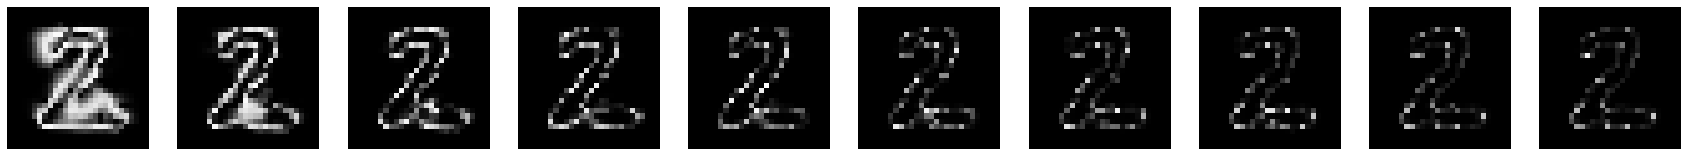

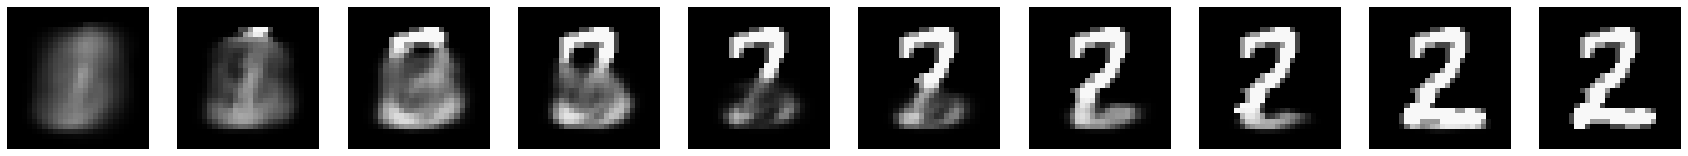

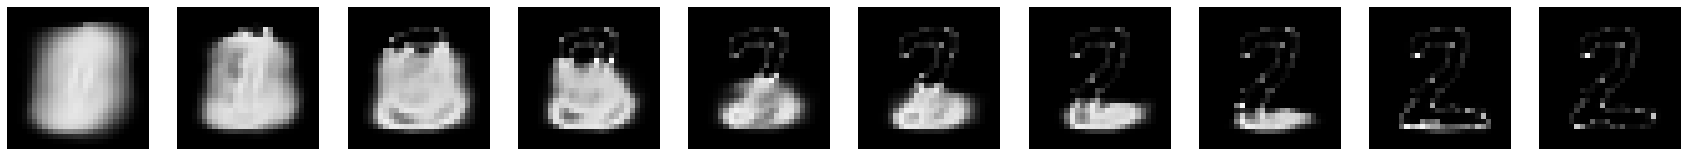

Step 101137, Loss (last minibatch): 0.20307350158691406, Loss (500 step avg.): 0.2138198707810419


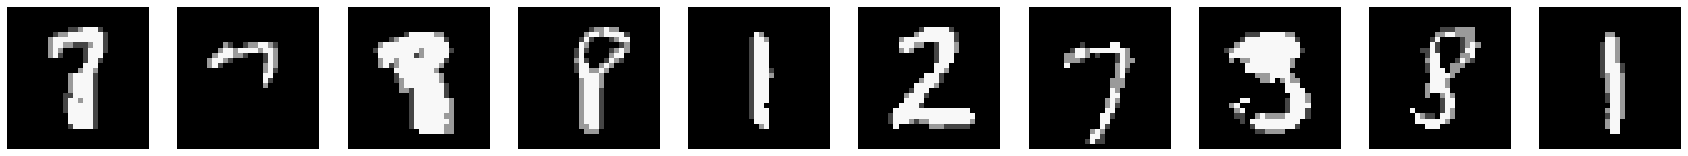

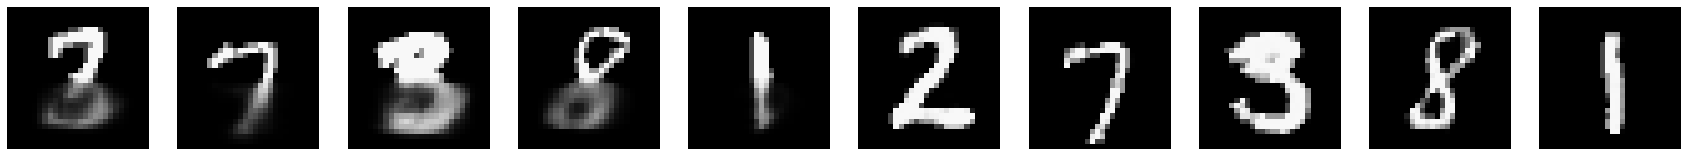

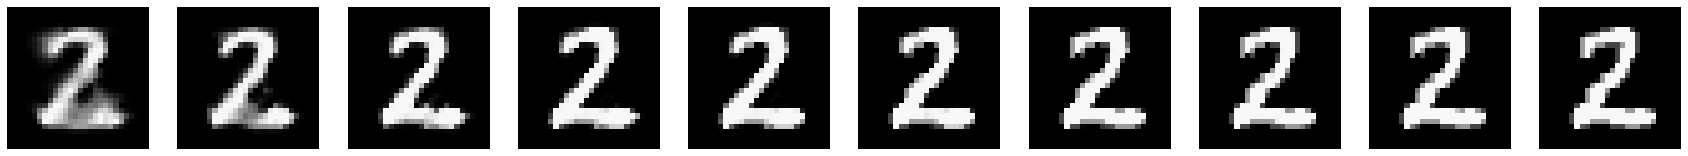

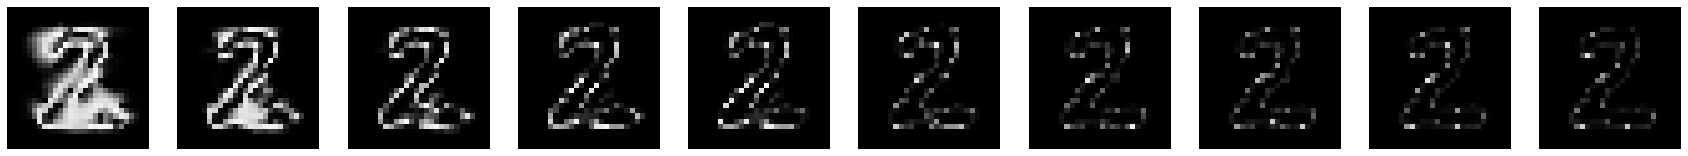

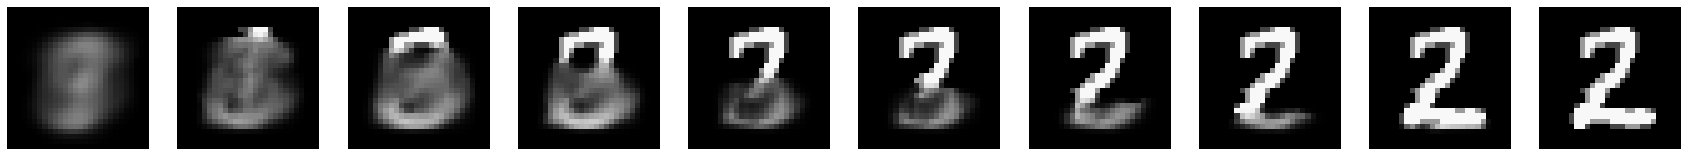

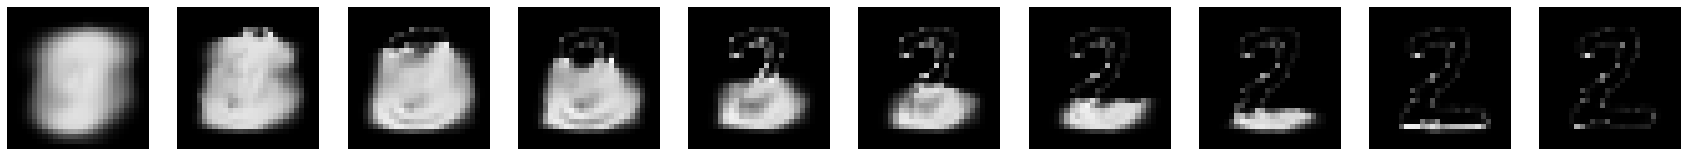

Step 106137, Loss (last minibatch): 0.24443352222442627, Loss (500 step avg.): 0.21324683080414336


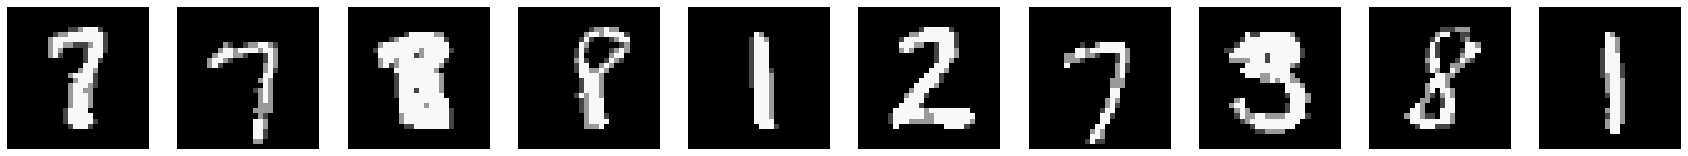

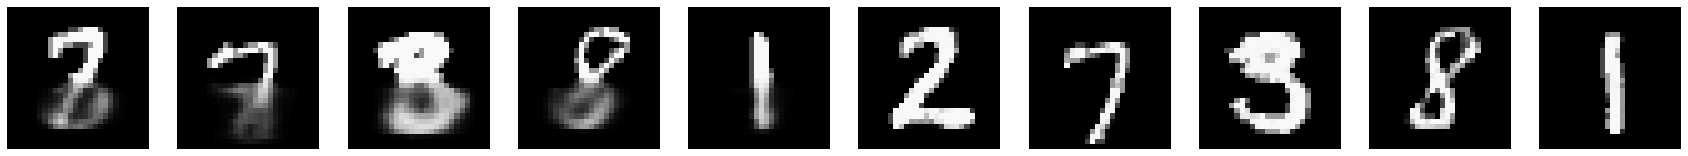

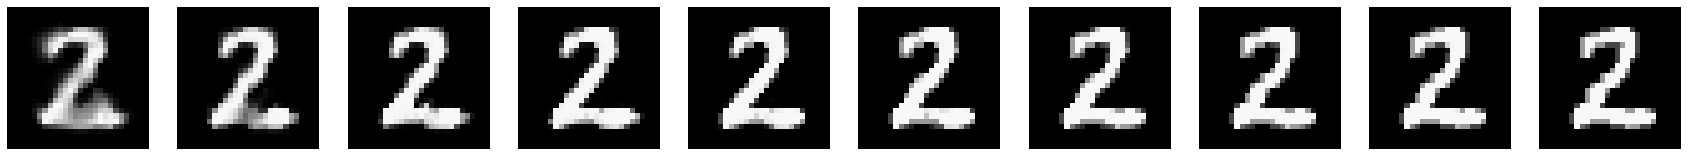

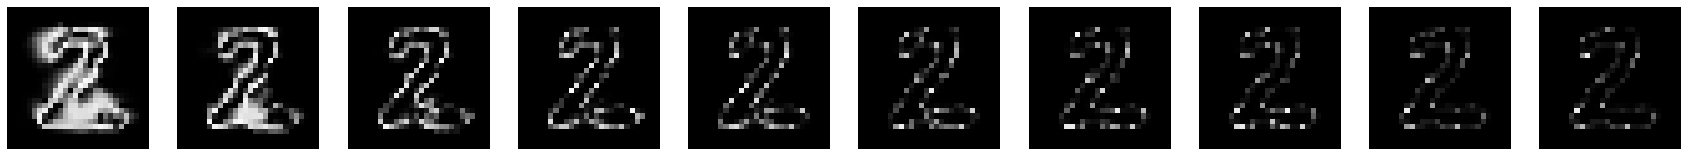

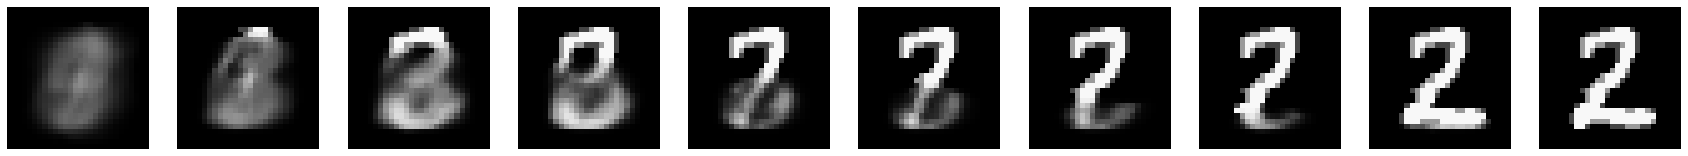

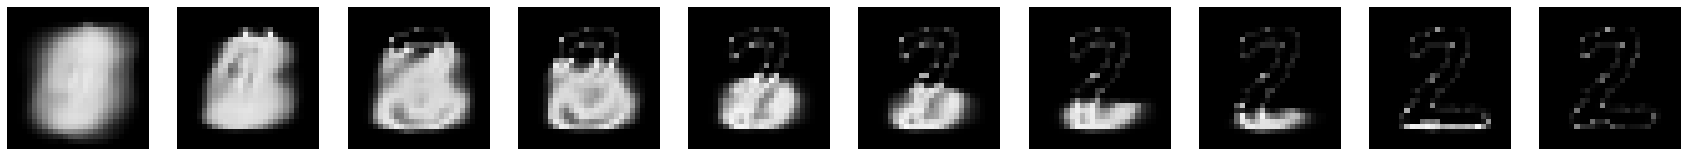

Step 111137, Loss (last minibatch): 0.22711360454559326, Loss (500 step avg.): 0.2141861555997483


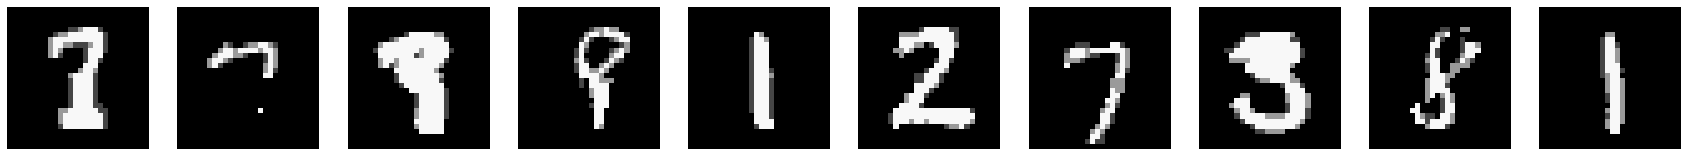

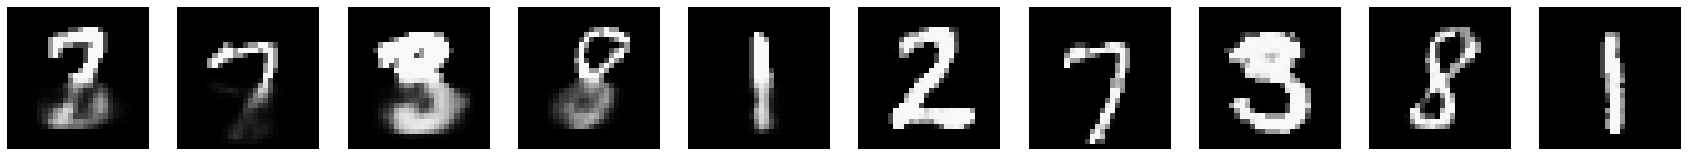

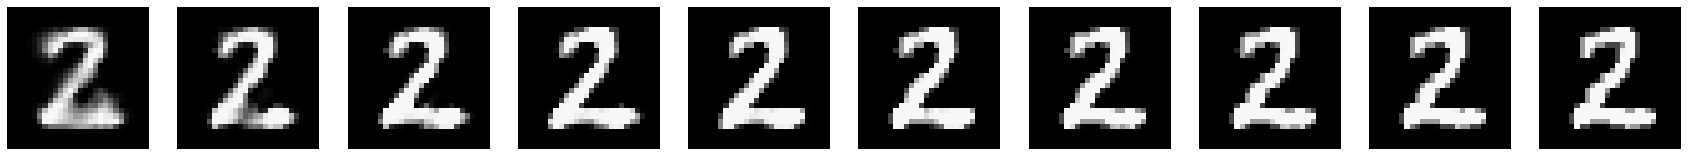

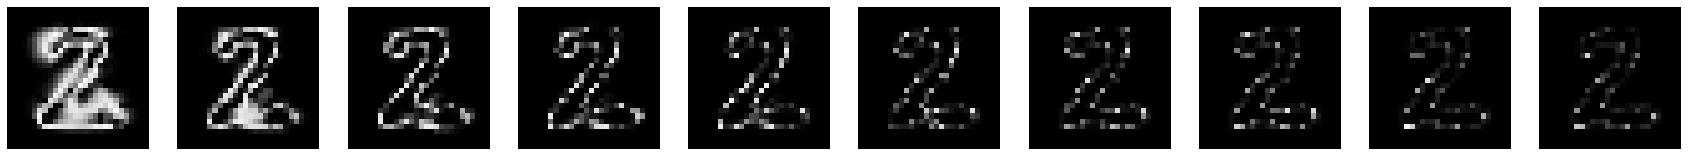

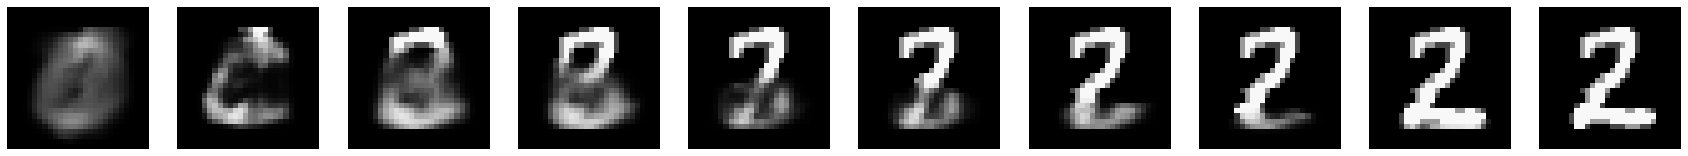

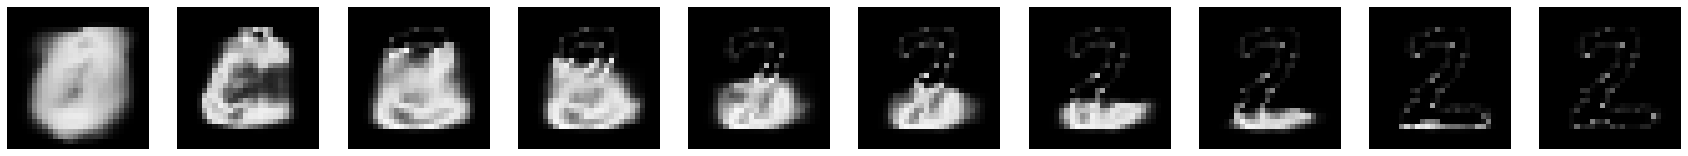

Step 116137, Loss (last minibatch): 0.18941234052181244, Loss (500 step avg.): 0.21347993228606835


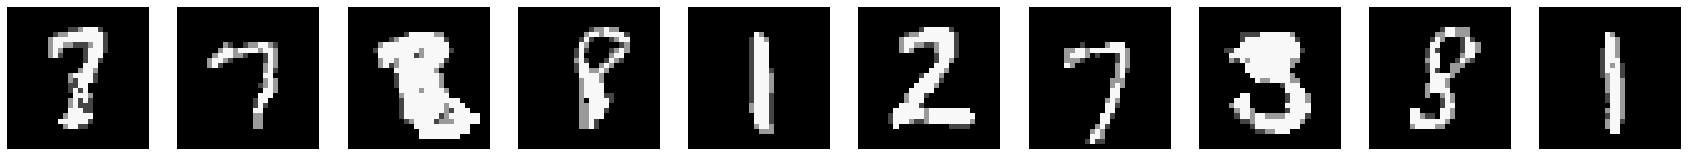

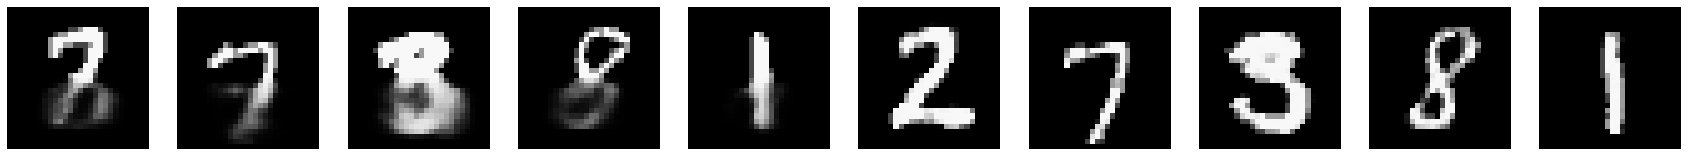

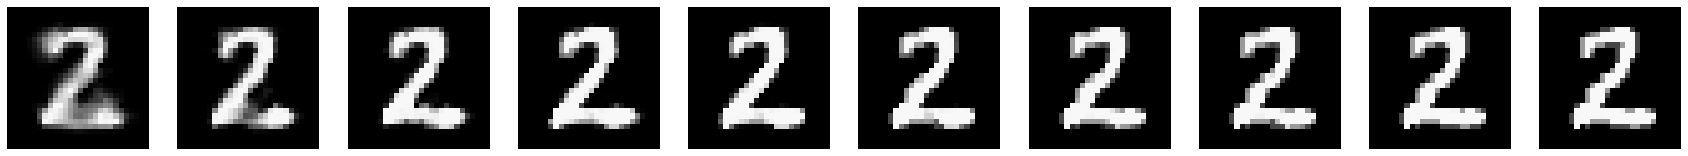

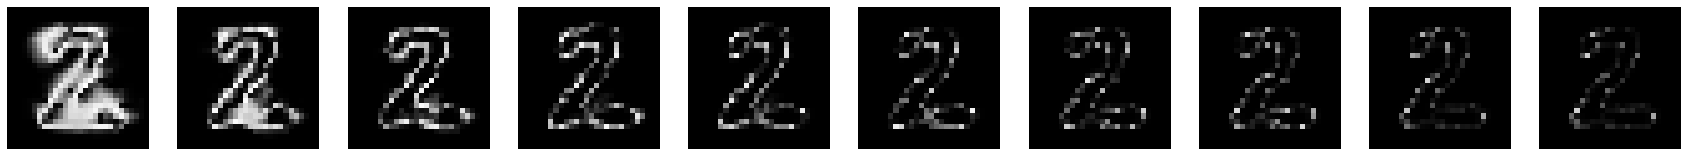

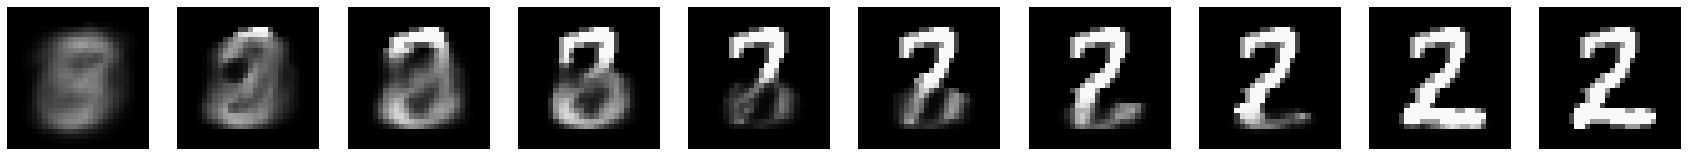

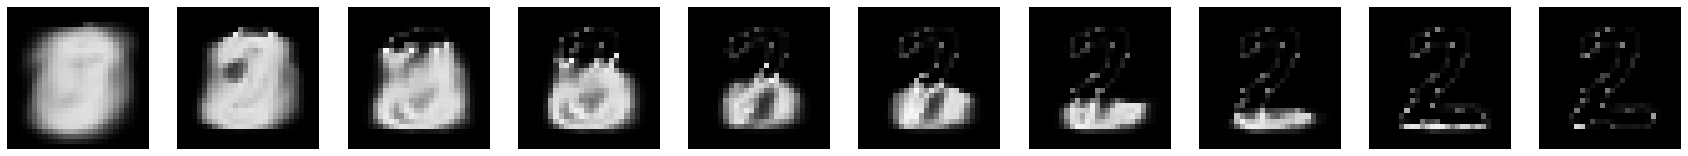

In [8]:
evaler = training.Evaluator(config, model, optimizer, viz, ds, ds_train_dist, ds_test)

training_loop = training.TrainingLoop(config, evaler, model_name)

with strategy.scope():
    training_loop.train()

In [9]:
model.save(f"models/{model_name}")

INFO:tensorflow:Assets written to: models/cuda7.ecs.vuw.ac.nz-28x28-noise0.04-bs3x1x8/assets


INFO:tensorflow:Assets written to: models/cuda7.ecs.vuw.ac.nz-28x28-noise0.04-bs3x1x8/assets


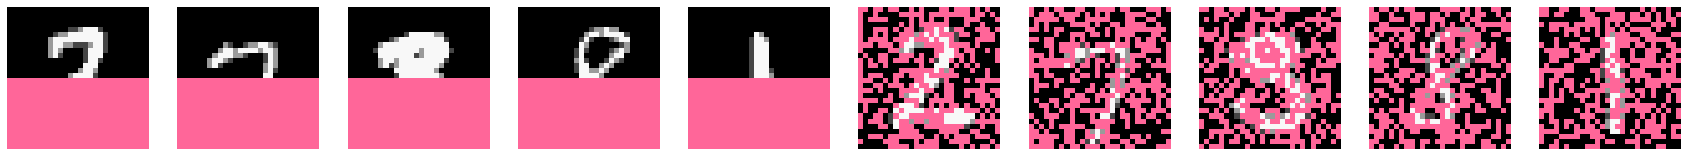

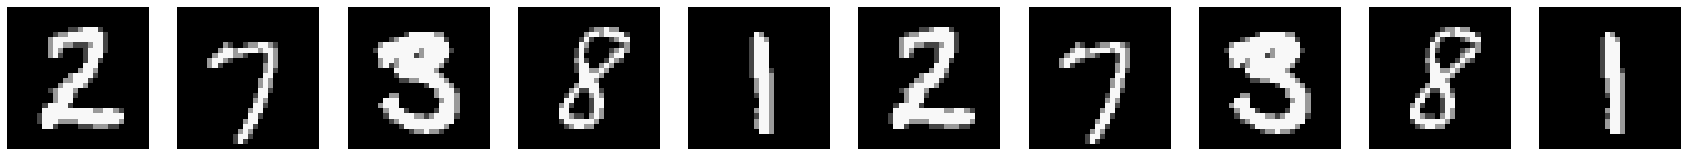

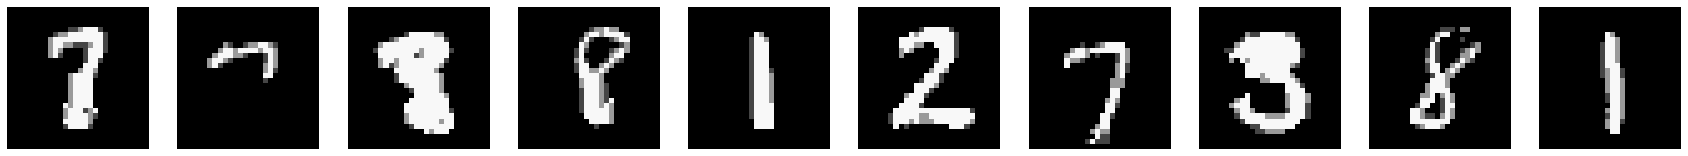

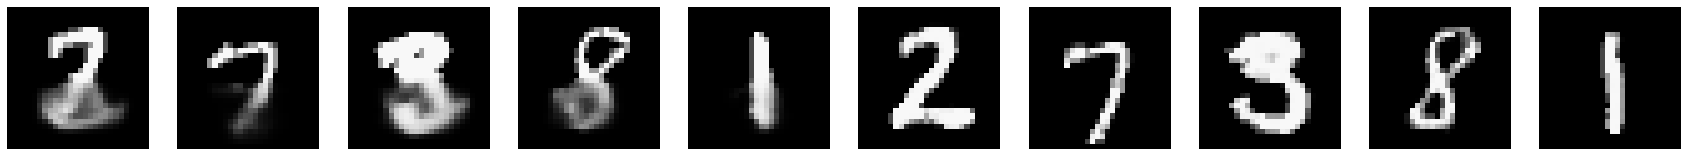

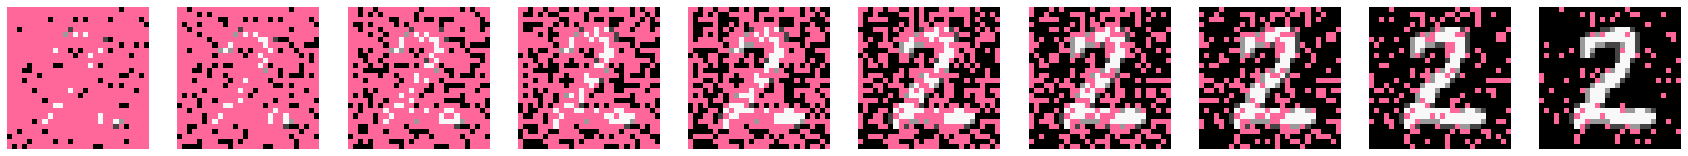

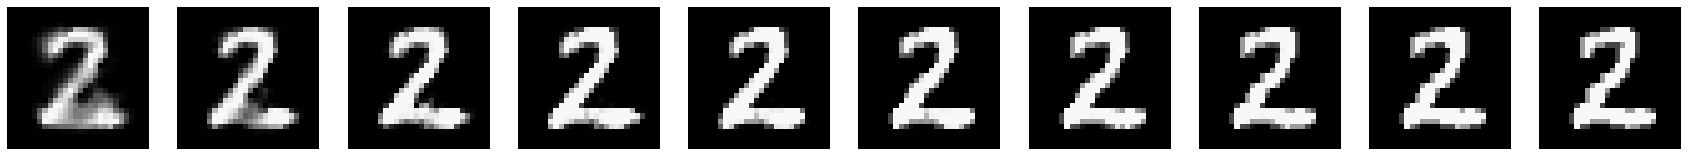

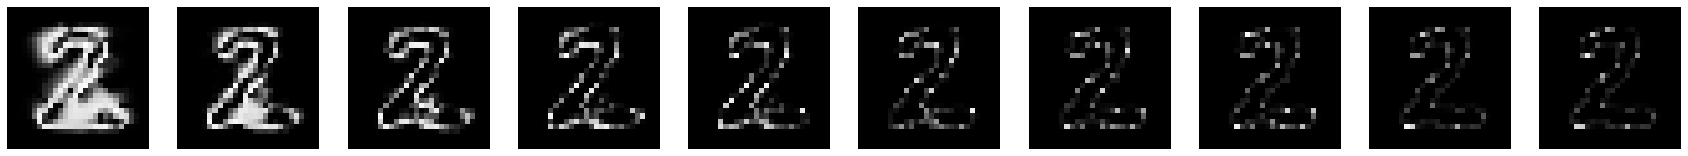

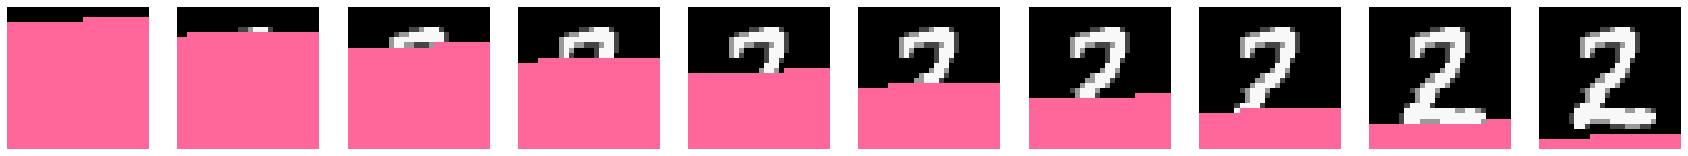

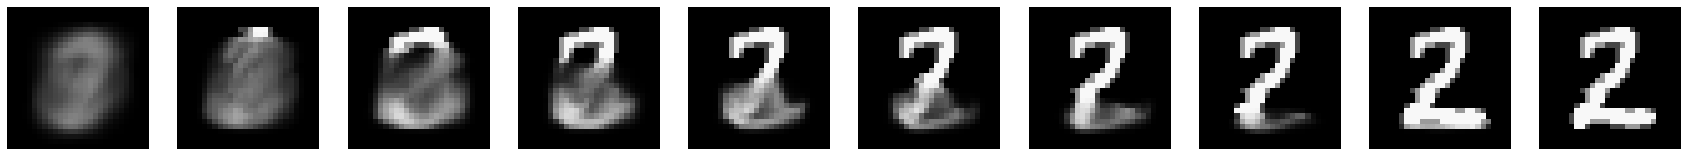

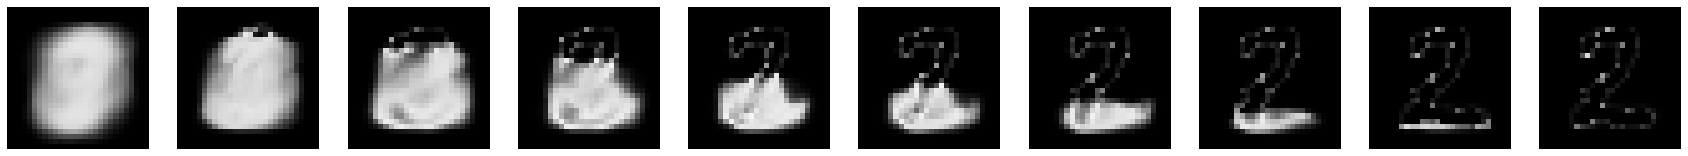

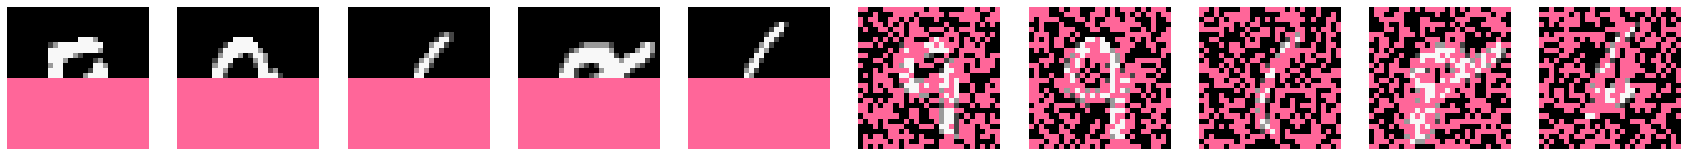

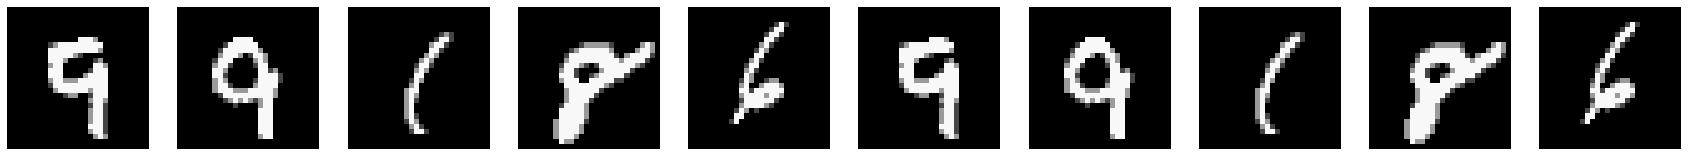

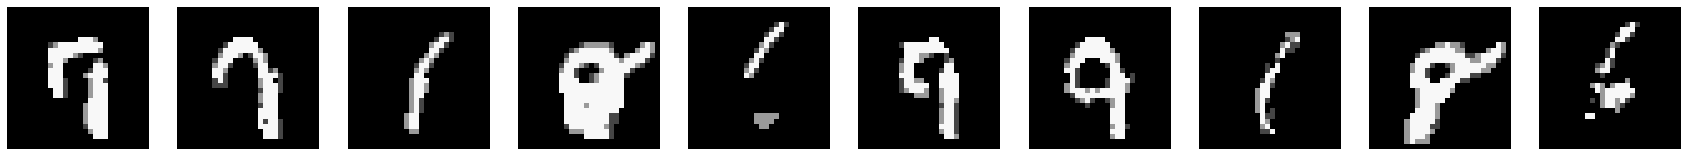

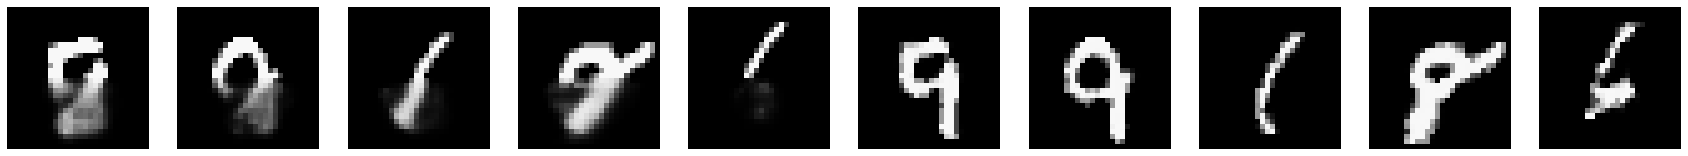

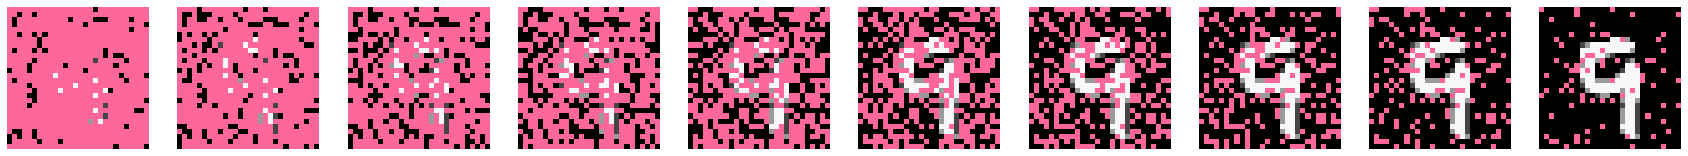

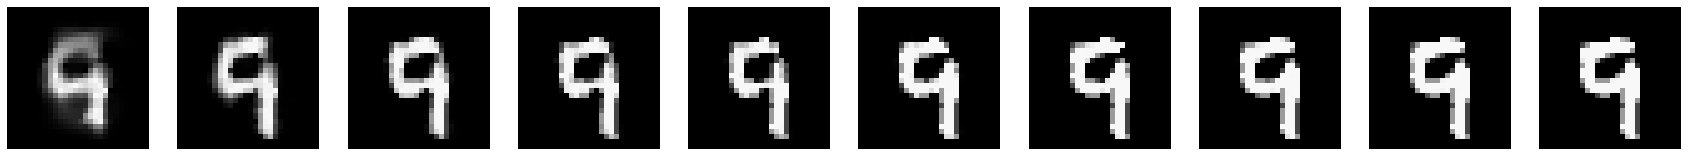

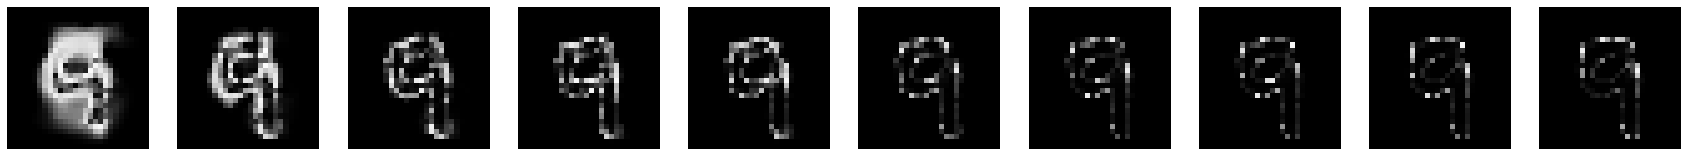

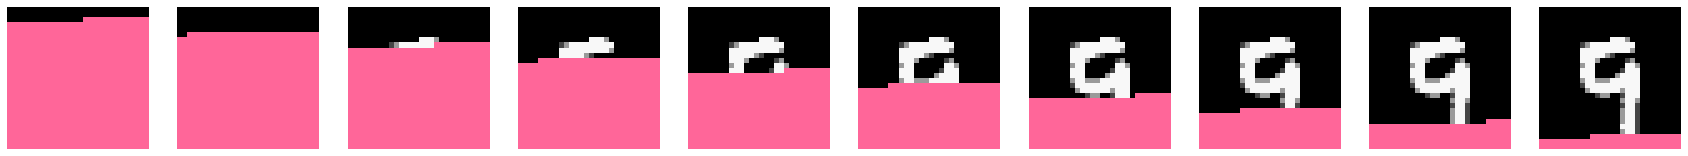

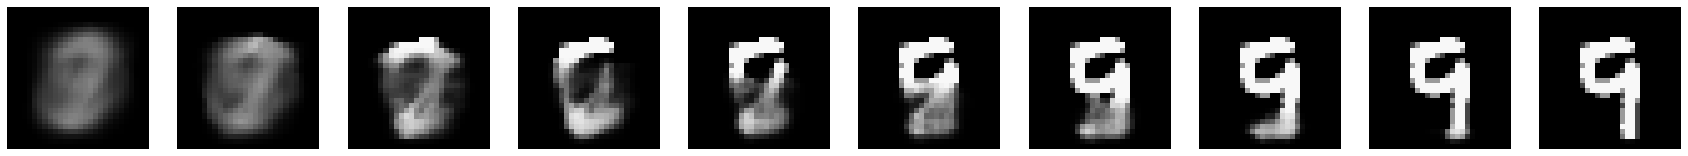

In [ ]:
evaler.process_batch(show_input=True)
evaler.new_test_batch()
evaler.process_batch(show_input=True)
